In [4]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import itertools
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization, DetailedBalance, segment_LLS, linear_cycle_utils
from pathlib import Path


def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [5]:
#get directories and open separated datasets

whichpcs = [2,7]
time_interval = 5 #sec/frame

datadir = 'E:/Aaron/random_lls/'
savedir = datadir + 'random_longtracks/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())

#restrict dataframe to only random experiments
TotalFrame = TotalFrame[TotalFrame.Treatment=='Random']


#list of behavioral stats to track with CGPS transitions
behaviorstats = ['speed','persistence','Turn_Angle','directional_autocorrelation','time']

#find the length of cell consecutive frames
results = []
for i, cells in TotalFrame.groupby('CellID'):
    cells = cells.sort_values('time').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    maxrun = max([len(l) for l in runs])
    sumrun = sum([len(l) for l in runs])
    actualrun = max(runs, key=len, default=[])
    results.append([i, maxrun, actualrun, sumrun])
#find
stdf = pd.DataFrame(results, columns = ['CellID','length_of_run','actual_run','total_runs']).sort_values('total_runs', ascending=False).reset_index(drop=True)
#get cells with more than 30 minutes of continuous footage
longcells = stdf[stdf.total_runs>360].CellID.to_list()
TotalFrame = TotalFrame[TotalFrame.CellID.isin(longcells)].copy()
stdf

CellID  length_of_run  \
0    20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_c...             73   
1    20240611_488_EGFP-CAAX_640_actin-halotag_cell7_01             42   
2    20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01             40   
3    20240524_488_EGFP-CAAX_640_actin-halotag_cell2_01             40   
4    20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_c...             36   
..                                                 ...            ...   
97      20240527_488_EGFP-CAAX_640_SPY650-DNA_cell3_06              4   
98   20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_c...              2   
99      20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2_02              2   
100  20240524_488_EGFP-CAAX_640_actin-halotag_cell2_06              1   
101     20240805_488_EGFP-CAAX_640_SPY650-DNA_cell3_07              1   

                                            actual_run  total_runs  
0    [164, 165, 166, 167, 168, 169, 170, 171, 172, ...         618  
1    [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...         546  
2    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...         543  
3    [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 5...         529  
4    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...         529  
..                                                 ...         ...  
97                                        [4, 5, 6, 7]           4  
98                                              [1, 2]           3  
99                                              [1, 2]           2  
100                                                [1]           1  
101                                                [7]           1  

[102 rows x 4 columns]

In [6]:
########### interpolate all transitions so that only individual transitions are made ###########

if (os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transitions.csv')) & (os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs.csv')):
    
    rawtransdf = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transitions.csv', index_col = 0)
    rawtranspairsdf = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs.csv', index_col = 0)
    
    transdf = pd.read_csv(savedir+f'interpolated_PC{whichpcs[0]}-PC{whichpcs[1]}_transitions.csv', index_col = 0)
    transpairsdf = pd.read_csv(savedir+f'interpolated_PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs.csv', index_col = 0)
    print('Opened transition files')
    
else:

    rawresults = []
    results = []
    for i, cells in TotalFrame.groupby('CellID'):
        cells = cells.sort_values('time').reset_index(drop = True)
        diff = cells.time.diff()
        difflist = [0]
        difflist.extend(diff[diff>5].index.to_list())
        runs = []
        for x in range(len(difflist)-1):
            runs.append(list(range(difflist[x], difflist[x+1])))
        #start with time zero
        timeadd = 0
        rawtimeadd = 0
        for r in runs:
            r = np.array(r, dtype=int)
            #skip runs less than 3 frames long
            if len(r)<2:
                pass
            else:
                cell = cells.iloc[r]
                #get raw trajectories
                (rawtrajint, rawpairs) = DetailedBalance.pair_transitions(
                            time_interval,
                            cell.CellID.iloc[0],
                            cell.frame.to_list(),
                            cell[[f'PC{whichpcs[0]}bins',f'PC{whichpcs[1]}bins']].to_numpy(),
                            )
                #interpolate trajectories
                (trajint, pairs) = DetailedBalance.interpolate_2dtrajectory(
                    time_interval,
                    cell.CellID.iloc[0],
                    cell.frame.to_list(),
                    cell[[f'PC{whichpcs[0]}bins',f'PC{whichpcs[1]}bins']].to_numpy(),
                    )
                if any(trajint):
                    #add time
                    rawtrajint = pd.DataFrame(rawtrajint)
                    rawtrajint['cumulative_time'] = rawtrajint['cumulative_time'] + rawtimeadd
                    rawtimeadd = rawtrajint['cumulative_time'].iloc[-1]
                    #add some behavioral stats to correlate later with aer
                    rawtrajint[behaviorstats] = cell[behaviorstats].iloc[1:].reset_index(drop = True)
                    rawresults.append([rawtrajint,rawpairs])
                    #add time
                    trajint = pd.DataFrame(trajint)
                    trajint['cumulative_time'] = trajint['cumulative_time'] + timeadd
                    timeadd = trajint['cumulative_time'].iloc[-1]
                    results.append([trajint,pairs])
                    
    
    rawtransdf = pd.concat([r[0] for r in rawresults]).reset_index(drop=True)
    rawtranspairsdf = pd.DataFrame(sum([r[1] for r in rawresults],[]))
    rawtransdf.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transitions.csv')
    rawtranspairsdf.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs.csv')
    
    transdf = pd.concat([r[0] for r in results]).reset_index(drop=True)
    transpairsdf = pd.DataFrame(sum([r[1] for r in results],[]))
    transdf.to_csv(savedir+f'interpolated_PC{whichpcs[0]}-PC{whichpcs[1]}_transitions.csv')
    transpairsdf.to_csv(savedir+f'interpolated_PC{whichpcs[0]}-PC{whichpcs[1]}_transition_pairs.csv')

    print('Calculated transitions')
    
    
    
############## get the counts of cells leaving 

if os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_binned_transition_rates.csv'):
    trans_rate_df = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_binned_transition_rates.csv', index_col = 0)
    print('Opened transition rate files')
else:
    
    trresults = []
    if __name__ ==  '__main__':
        for m, mig in transdf.groupby('CellID'):
            ttot = mig.time_elapsed.sum()
            print(ttot)
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(nbins):
                for y in range(nbins):
                    fromm = mig[(mig['from_x'] == x+1) & (mig['from_y'] == y+1)].reset_index(drop=True).to_dict()
                    to = mig[(mig['to_x'] == x+1) & (mig['to_y'] == y+1)].reset_index(drop=True).to_dict()
                    pool.apply_async(DetailedBalance.get_transition_counts, args = (
                        x+1,
                        y+1,
                        fromm,
                        to,
                        ttot,
                        ),
                        callback = collect_results)
            pool.close()
            pool.join()

            trans_rate_df_sep = pd.DataFrame(results)
            trans_rate_df_sep['CellID'] = [m]*len(trans_rate_df_sep)
            trans_rate_df_sep = trans_rate_df_sep.sort_values(by = ['x','y']).reset_index(drop=True)
            trresults.append(trans_rate_df_sep)
            
            
    trans_rate_df_sep = pd.concat(trresults)
    trans_rate_df_sep.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_binned_transition_rates.csv')
    del trresults
    
    print('Calculated transition rates')
    
    

# ############## BOOTSTRAP MANY TRAJECTORIES ##########
# #if a bootstrapped data file already exists, load it, otherwise make one
# if os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transition_rates.csv') and os.path.exists(savedir+f'PC1-PC7_bootstrapped_transitions.csv'):
#     bsframe_sep_full = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transition_rates.csv', index_col=0)
#     bstrans = pd.read_csv(savedir+f'PC1-PC7_bootstrapped_transitions.csv', index_col=0)
#     print('Opened bootstrap file')
# else:
    
#     #number of times to bootstrap
#     bsiter = 3000
#     bsresults = []
#     bsrates = []
#     for m, mig in transpairsdf_sep.groupby('CellID'):
#         #set the total bootstrap time to the full time observed for this sample
#         ttot = TotalFrame.frame.max()*time_interval#mig.time_elapsed.sum()
            
#         start = 0
#         stop = 300
#         allresults = []
#         while start<bsiter:
#             print(f'Finished {m} {start}, starting {start}-{stop}')
#             if __name__ ==  '__main__':
#                 pool = multiprocessing.Pool(processes=60)
#                 results = []
#                 for x in range(start,stop+1):
#                     pool.apply_async(bootstrap_trajectories, args = (
#                         mig,
#                         ttot,
#                         nbins,
#                         ),
#                         callback = collect_results)
#                 pool.close()
#                 pool.join()

#                 allresults.extend(results)

#             start = stop + 1
#             stop = stop + 300
#             if stop>bsiter:
#                 stop = bsiter

                
#         for i, a in enumerate(allresults):
#              a['iter'] = i
#         migboot = pd.concat(allresults).reset_index(drop=True)
#         migboot['CellID'] = [m]*len(migboot)
#         bsresults.append(migboot)

#         ### now get transition rates
#         start = 0
#         stop = 300
#         allresults = []
#         while start<bsiter:
#             print(f'Finished {m} rates {start}, starting {start}-{stop}')
#             if __name__ ==  '__main__':
#                 pool = multiprocessing.Pool(processes=60)
#                 results = []
#                 for i in range(start,stop+1):
#                     tempmig = migboot[migboot.iter == i]
#                     ct = tempmig.time_elapsed.sum()
#                     pool.apply_async(transition_count_wrapper, args = (
#                         tempmig,
#                         nbins,
#                         ct,
#                         ),
#                         callback = collect_results)
#                 pool.close()
#                 pool.join()

#                 allresults.extend(results)

#             start = stop + 1
#             stop = stop + 300
#             if stop>bsiter:
#                 stop = bsiter
                
#         migrate = pd.concat(allresults).reset_index(drop=True)
#         migrate['CellID'] = pd.Categorical([m]*len(migrate), categories=['DMSO','Para-Nitro-Blebbistatin'], ordered=True)
#         iters = [[x]*(nbins**2) for x in range(int(len(migrate)/(nbins**2)))]
#         migrate['bs_iteration'] = list(itertools.chain.from_iterable(iters))
#         bsrates.append(migrate)
        

        
        
        
#     bstrans = pd.concat(bsresults)
#     bstrans.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transitions.csv')
#     bsframe_sep_full = pd.concat(bsrates)
#     bsframe_sep_full.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transition_rates.csv')
#     del migboot
#     del bsrates
#     del bsresults
#     del results
#     del allresults
#     print('Finished bootstrapping')


# ############# open average bootstrapped currents ###################
# if (os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transitions_average_currents.csv')):
    
#     bsfield_sep = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transitions_average_currents.csv', index_col=0)

#     print('Opened boostrapped average currents')
    
# else:
#     #### get current field for this bootstrap realization ######
#     ####### this is for looking at data spread for the current field ############
#     bsfield = []

#     for x in range(nbins):
#         for y in range(Ynbins):
#             current = bsframe_sep_full[(bsframe_sep_full['x'] == x+1) & (bsframe_sep_full['y'] == y+1)]
#             js = np.array([[[(row.x_plus_rate - row.x_minus_rate)/2, 0],[0,(row.y_plus_rate - row.y_minus_rate)/2]] for i, row in current.iterrows()])
#             avgjs = np.mean(js, axis = 0)
#             evals, evecs = np.linalg.eigh(avgjs)
#             bsfield.append({'x':x+1,
#                             'y':y+1,
#                             'eval1':evals[1],
#                             'eval2':evals[0],
#                            'evec1x':evecs[0,1],
#                            'evec1y':evecs[1,1],
#                            'evec2x':evecs[0,0],
#                            'evec2y':evecs[1,0]})

#     bsfield_sep = pd.DataFrame(bsfield)
#     bsfield_sep.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_bootstrapped_transitions_average_currents.csv')

Opened transition files
Opened transition rate files


In [ ]:

from aicsimageio.readers.ome_tiff_reader import OmeTiffReader
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
from aicsimageio.readers.czi_reader import CziReader
from CustomFunctions.MO_Threshold import MO_ma
import skimage
import numpy.ma as ma

ddir = '//10.158.28.35/TheriotLab_LLS7/Aaron/manual_crop_lls_decon/'
xy_buffer = 7
z_buffer = 7

cellname = '20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01'
cell = TotalFrame[TotalFrame.cell==cellname]
cell = cell.sort_values('time').reset_index(drop=True)
lst = []
for x in cell.cell.to_list():
    x = x.split('_frame')[0]
    if x not in lst:
        lst.append(x)
centroids = []
imagelist = []
framelist = []
for l in lst[-3:]:
    big = CziReader(ddir+l+'_deskewed_decon.czi')
    bigim = big.data
    orig_shape = big.shape
    cents = []
    reimlist = []
    croplist = []
    for i in range(orig_shape[-5]):
        ### get the shape of the rescaled to use later to leave out objects
        rescaled = skimage.transform.rescale(bigim[i,1,:,:,:],0.25, preserve_range=True)
        rescaledother = skimage.transform.rescale(bigim[i,0,:,:,:],0.25, preserve_range=True)
        shape = rescaled.shape
        #mask the top pixels with signal
        if rescaled.max()<100:
            print(f'frame {i} from video {l} is probably missing')
            continue
        mare = ma.masked_array(rescaled, mask = rescaled>np.percentile(rescaled[rescaled>100], 97))
        seg = MO_ma(mare, global_thresh_method='tri', object_minArea=200, local_adjust = 0.92)
        im_labeled, n_labels = skimage.measure.label(
                                  seg, background=0, return_num=True,  )
        im_props = skimage.measure.regionprops(im_labeled)
        tempdf = pd.DataFrame([])
        for count, prop in enumerate(im_props):
            z,y,x = prop.centroid
            thebox = np.array(prop.bbox)
            area = prop.area * 64
            td = {'cell':count, 'z_min':thebox[0], 'y_min':thebox[1], 
                    'x_min':thebox[2],'z_max':thebox[3], 'y_max':thebox[4], 'x_max':thebox[5],
                   'z':z, 'y':y, 'x': x, 'z_range': seg.shape[-3], 'area':area}
            #ensure only things that aren't on the edge are chosen
            if (td['z_min']>0) and (td['y_min']>0) and (td['x_min']>0) and (td['z_max']/4<shape[-3]) and (td['y_max']/4<shape[-2]) and (td['x_max']/4<shape[-1]):
                tempdf = tempdf.append(td, ignore_index=True)

        if (len(tempdf)>0) and (tempdf.loc[tempdf['area'].idxmax(),'area']>50000):
            #return the largest object that isn't touching an edge    
            cropdict = tempdf.loc[tempdf['area'].idxmax()].to_dict()
        else:
            cropdict = {'cell':np.nan, 'z_min':np.nan, 'y_min':np.nan, 
                    'x_min':np.nan,'z_max':np.nan, 'y_max':np.nan, 'x_max':np.nan,
                   'z':np.nan, 'y':np.nan, 'x': np.nan, 'z_range': np.nan, 'area':np.nan}


        #actually crop the image
        #get the right cropping boundaries
        if math.isnan(cropdict['z_max']):
            print(f'frame {i} from video {l} couldnt be segmented')
        else:
            print(f'finished frame {i} from video {l}')
            xmincrop = int(max(0, cropdict['x_min']-xy_buffer))
            ymincrop = int(max(0, cropdict['y_min']-xy_buffer))
            zmincrop = int(max(0, cropdict['z_min']-z_buffer))
            zmaxcrop = int(min(cropdict['z_max']+z_buffer, shape[-3]))
            ymaxcrop = int(min(cropdict['y_max']+xy_buffer, shape[-2])+1)
            xmaxcrop = int(min(cropdict['x_max']+xy_buffer, shape[-1])+1)
            croplist.append([zmincrop,zmaxcrop,ymincrop,ymaxcrop,xmincrop,xmaxcrop])
            cents.append([cropdict['z'],cropdict['y'],cropdict['x']])
            reimlist.append(np.stack((rescaled,rescaledother)))
            #add this frame to the frame list so I know which frames were included in the video
            framelist.append(l+'_frame_'+'{:03d}'.format(i))

    #get the sizes for the movie and crop accordingly
    mincrop = np.min(np.array(croplist), axis = 0)
    maxcrop = np.max(np.array(croplist), axis = 0)
    rescaledall = np.stack(reimlist)
    imagelist.append(rescaledall[:,:,
                            mincrop[0]:maxcrop[1],
                          mincrop[2]:maxcrop[3],
                          mincrop[4]:maxcrop[5]])
    centroids.append(np.array(cents)-np.array([mincrop[0],mincrop[2],mincrop[4]]))

newc = []
for u, c in enumerate(centroids):
    if u!=0:
        newc.append(centroids[u-1][-1]-c[0])
    else:
        newc.append(np.zeros(3))
zeropos = np.stack(newc)
zeropos = np.cumsum(zeropos,axis=0)
zeropos = np.round(zeropos + abs(zeropos.min())+0.0001)
shapes = [x.shape for x in imagelist]
totalshape = np.round(np.max(zeropos + np.array(shapes)[:,-3:], axis = 0)-np.min(zeropos,axis=0)+0.001)
finalimage = np.zeros((np.concatenate([[sum([x[0]for x in shapes])],[2],totalshape]).astype(int)))
timecount = 0
shifts = zeropos-np.min(zeropos,axis=0)
for r in range(len(shapes)):
    s = shapes[r]
    z = shifts[r].astype(int)
    finalimage[timecount:timecount+s[0],
               :,
               z[-3]:z[-3]+s[-3],
               z[-2]:z[-2]+s[-2],
               z[-1]:z[-1]+s[-1],
              ] = imagelist[r]
    timecount = timecount+s[0]


In [401]:
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
from aicsimageio.readers.czi_reader import CziReader
from CustomFunctions.MO_Threshold import MO_ma
import skimage
import numpy.ma as ma

ddir = '//10.158.28.35/TheriotLab_LLS7/Aaron/manual_crop_lls_decon/'
xy_buffer = 7
z_buffer = 7

for cellname, cell in TotalFrame.groupby('CellID'):
    cell = cell.sort_values('time').reset_index(drop=True)
    lst = []
    for x in cell.cell.to_list():
        x = x.split('_frame')[0]
        if x not in lst:
            lst.append(x)
    centroids = []
    imagelist = []
    framelist = []
    for l in lst:
        big = CziReader(ddir+l+'_deskewed_decon.czi')
        bigim = big.data
        orig_shape = big.shape
        cents = []
        reimlist = []
        croplist = []
        for i in range(orig_shape[-5]):
            ### get the shape of the rescaled to use later to leave out objects
            rescaled = skimage.transform.rescale(bigim[i,1,:,:,:],0.25, preserve_range=True)
            rescaledother = skimage.transform.rescale(bigim[i,0,:,:,:],0.25, preserve_range=True)
            shape = rescaled.shape
            #mask the top pixels with signal
            if rescaled.max()<100:
                print(f'frame {i} from video {l} is probably missing')
                continue
            mare = ma.masked_array(rescaled, mask = rescaled>np.percentile(rescaled[rescaled>100], 97))
            seg = MO_ma(mare, global_thresh_method='tri', object_minArea=200, local_adjust = 0.92)
            im_labeled, n_labels = skimage.measure.label(
                                      seg, background=0, return_num=True,  )
            im_props = skimage.measure.regionprops(im_labeled)
            tempdf = pd.DataFrame([])
            for count, prop in enumerate(im_props):
                z,y,x = prop.centroid
                thebox = np.array(prop.bbox)
                area = prop.area * 64
                td = {'cell':count, 'z_min':thebox[0], 'y_min':thebox[1], 
                        'x_min':thebox[2],'z_max':thebox[3], 'y_max':thebox[4], 'x_max':thebox[5],
                       'z':z, 'y':y, 'x': x, 'z_range': seg.shape[-3], 'area':area}
                #ensure only things that aren't on the edge are chosen
                if (td['z_min']>0) and (td['y_min']>0) and (td['x_min']>0) and (td['z_max']/4<shape[-3]) and (td['y_max']/4<shape[-2]) and (td['x_max']/4<shape[-1]):
                    tempdf = tempdf.append(td, ignore_index=True)

            if (len(tempdf)>0) and (tempdf.loc[tempdf['area'].idxmax(),'area']>50000):
                #return the largest object that isn't touching an edge    
                cropdict = tempdf.loc[tempdf['area'].idxmax()].to_dict()
            else:
                cropdict = {'cell':np.nan, 'z_min':np.nan, 'y_min':np.nan, 
                        'x_min':np.nan,'z_max':np.nan, 'y_max':np.nan, 'x_max':np.nan,
                       'z':np.nan, 'y':np.nan, 'x': np.nan, 'z_range': np.nan, 'area':np.nan}


            #actually crop the image
            #get the right cropping boundaries
            if math.isnan(cropdict['z_max']):
                print(f'frame {i} from video {l} couldnt be segmented')
            else:
                print(f'finished frame {i} from video {l}')
                xmincrop = int(max(0, cropdict['x_min']-xy_buffer))
                ymincrop = int(max(0, cropdict['y_min']-xy_buffer))
                zmincrop = int(max(0, cropdict['z_min']-z_buffer))
                zmaxcrop = int(min(cropdict['z_max']+z_buffer, shape[-3]))
                ymaxcrop = int(min(cropdict['y_max']+xy_buffer, shape[-2])+1)
                xmaxcrop = int(min(cropdict['x_max']+xy_buffer, shape[-1])+1)
                croplist.append([zmincrop,zmaxcrop,ymincrop,ymaxcrop,xmincrop,xmaxcrop])
                cents.append([cropdict['z'],cropdict['y'],cropdict['x']])
                reimlist.append(np.stack((rescaled,rescaledother)))
                #add this frame to the frame list so I know which frames were included in the video
                framelist.append(l+'_frame_'+'{:03d}'.format(i))
                
        #get the sizes for the movie and crop accordingly
        mincrop = np.min(np.array(croplist), axis = 0)
        maxcrop = np.max(np.array(croplist), axis = 0)
        rescaledall = np.stack(reimlist)
        imagelist.append(rescaledall[:,:,
                                mincrop[0]:maxcrop[1],
                              mincrop[2]:maxcrop[3],
                              mincrop[4]:maxcrop[5]])
        centroids.append(np.array(cents)-np.array([mincrop[0],mincrop[2],mincrop[4]]))

    newc = []
    for u, c in enumerate(centroids):
        if u!=0:
            newc.append(centroids[u-1][-1]-c[0])
        else:
            newc.append(np.zeros(3))
    zeropos = np.stack(newc)
    zeropos = np.cumsum(zeropos,axis=0)
    zeropos = np.round(zeropos + abs(zeropos.min())+0.0001)
    shapes = [x.shape for x in imagelist]
    totalshape = np.round(np.max(zeropos + np.array(shapes)[:,-3:], axis = 0)-np.min(zeropos,axis=0)+0.001)
    finalimage = np.zeros((np.concatenate([[sum([x[0]for x in shapes])],[2],totalshape]).astype(int)))
    timecount = 0
    shifts = zeropos-np.min(zeropos,axis=0)
    for r in range(len(shapes)):
        s = shapes[r]
        z = shifts[r].astype(int)
        finalimage[timecount:timecount+s[0],
                   :,
                   z[-3]:z[-3]+s[-3],
                   z[-2]:z[-2]+s[-2],
                   z[-1]:z[-1]+s[-1],
                  ] = imagelist[r]
        timecount = timecount+s[0]

    indivdir = savedir + 'singlecells/'+ cellname +'/'
    if not os.path.exists(indivdir):
        os.makedirs(indivdir)
    OmeTiffWriter.save(finalimage.astype('uint16'),indivdir+f'{cellname}_full_movie.ome.tiff')
    pd.Series(framelist).to_csv(indivdir+f'{cellname}_framelist.csv')

finished frame 0 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 1 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 2 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 3 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 4 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 5 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 6 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 7 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 8 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 9 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 10 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-

finished frame 89 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 90 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 91 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 92 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 93 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 94 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 95 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 96 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 97 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 98 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 99 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 177 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 178 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 179 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 180 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 181 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 182 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 183 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 184 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 185 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 186 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 187 from video 20240520_488_EGFP-CAAX_561_mys

finished frame 18 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 19 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 20 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 21 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 22 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 23 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 24 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 25 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 26 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 27 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 28 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 27 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 28 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 29 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 30 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 31 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 32 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 33 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 34 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 35 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 36 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 37 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 8 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 9 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 10 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 11 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 12 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 13 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 14 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 15 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 16 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 17 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 18 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37

finished frame 74 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 75 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 76 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 77 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 78 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 79 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 80 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 81 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 82 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 83 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 84 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 162 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 163 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 164 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 165 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 166 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 167 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 168 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 169 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 170 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 171 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 172 from video 20240520_488_EGFP-CAAX_561_mys

finished frame 13 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 14 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 15 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 16 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 17 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 18 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 19 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 20 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 21 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 22 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 23 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 2 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 3 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 4 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 5 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 6 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 7 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 8 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 9 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 10 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 11 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01
finished frame 12 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell

finished frame 40 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 41 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 42 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 43 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 44 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 45 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 46 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 47 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 48 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 49 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01
finished frame 50 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 13 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 14 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 15 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 16 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 17 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 18 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 19 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 20 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 21 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 22 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01
finished frame 23 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 45 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 46 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 47 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 48 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 49 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 50 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 51 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 52 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 53 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 54 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-14-Subset-01
finished frame 55 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 5 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 6 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 7 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 8 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 9 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 10 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 11 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 12 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 13 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 14 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-16-Subset-01
finished frame 15 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_c

finished frame 9 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 10 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 11 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 12 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 13 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 14 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 15 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 16 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 17 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 18 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-19-Subset-01
finished frame 19 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_3

finished frame 21 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 22 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 23 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 24 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 25 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 26 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 27 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 28 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-01-Subset-01
finished frame 0 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 1 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-03-Subset-01
finished frame 2 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C

finished frame 58 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 59 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 60 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 61 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 62 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 63 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 64 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 65 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 66 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 67 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-04-Subset-01
finished frame 68 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 13 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 14 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 15 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-06-Subset-01
finished frame 0 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 1 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 2 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 3 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 4 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 5 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 6 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-07-Subset-01
finished frame 7 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell

finished frame 61 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 62 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 63 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 64 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 65 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 66 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 67 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 68 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 69 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-08-Subset-01
finished frame 0 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-09-Subset-01
finished frame 1 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37

finished frame 23 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 24 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 25 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 26 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 27 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 28 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 29 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 30 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 31 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 32 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-12-Subset-01
finished frame 33 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 27 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 28 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 29 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 30 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 31 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 32 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 33 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 34 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 35 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 36 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-15-Subset-01
finished frame 37 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 25 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 26 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 27 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 28 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 29 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 30 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 31 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 32 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 33 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 34 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3-16-Subset-01
finished frame 35 from video 20240523_488_EGFP-CAAX_561_mysoin-mApple_

finished frame 37 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 38 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 39 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 40 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 41 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 42 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 43 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 44 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 45 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 46 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 47 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-02-Subset-01
finished frame 48 fro

finished frame 2 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 3 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 4 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 5 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 6 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 7 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 8 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 9 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 10 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 11 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 12 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-05-Subset-01
finished frame 13 from video 

finished frame 39 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 40 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 41 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 42 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 43 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 44 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 45 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 46 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 47 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 48 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 49 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01
finished frame 0 from

finished frame 33 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 34 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 35 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 36 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 37 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 38 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 39 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 40 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 41 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 42 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 43 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 44 fro

finished frame 125 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 126 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 127 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 128 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 129 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 130 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 131 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 132 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 133 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 134 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 135 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished f

finished frame 217 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 218 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 219 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 220 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 221 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 222 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 223 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 224 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 225 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 226 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished frame 227 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-11-Subset-01
finished f

finished frame 34 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 35 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 36 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 37 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 38 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 39 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 40 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 41 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 42 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 43 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell1-14-Subset-01
finished frame 0 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-02-Subset-01
finished frame 1 from 

finished frame 35 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 36 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 37 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 38 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 39 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 40 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 41 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 42 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 43 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 44 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 45 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 46 fro

finished frame 17 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 18 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 19 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 20 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 21 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 22 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 23 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 24 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 25 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 26 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 27 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 28 fro

finished frame 65 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 66 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 67 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 68 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 69 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 70 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 71 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 72 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 73 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 74 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 75 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 76 fro

finished frame 26 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 27 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 28 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 29 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 30 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 31 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 32 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 33 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 34 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 35 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 36 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-09-Subset-01
finished frame 37 fro

finished frame 68 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 69 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 70 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 71 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 72 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 73 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 74 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 75 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 76 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 77 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 78 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 79 fro

finished frame 54 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 55 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 56 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 57 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 58 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 59 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 60 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 61 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 62 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 63 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 64 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 65 fro

finished frame 13 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 14 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 15 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 16 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 17 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 18 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 19 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 20 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 21 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 22 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 23 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell2-12-Subset-01
finished frame 24 fro

finished frame 30 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 31 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 32 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 33 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 34 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 35 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 36 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 37 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 38 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 39 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 40 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-02-Subset-01
finished frame 41 fro

finished frame 51 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 52 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 53 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 54 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 55 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 56 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 57 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 58 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 59 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 60 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 61 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 62 fro

finished frame 143 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 144 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 145 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 146 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 147 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 148 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 149 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 150 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 151 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 152 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished frame 153 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-04-Subset-01
finished f

finished frame 15 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 16 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 17 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 18 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 19 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 20 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 21 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 22 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 23 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 24 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-05-Subset-01
finished frame 0 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-06-Subset-01
finished frame 1 from 

finished frame 83 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-06-Subset-01
finished frame 0 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 1 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 2 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 3 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 4 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 5 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 6 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 7 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 8 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 9 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 10 from video 20

finished frame 92 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 93 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 94 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 95 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 96 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 97 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 98 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 99 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 100 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 101 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 102 from video 20240524_488_EGFP-CAAX_640_actin-halotag_cell3-07-Subset-01
finished frame 103

finished frame 22 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 23 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 24 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 25 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 26 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 27 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 28 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 29 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 30 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 31 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 32 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 33 from video 20240527_488_EGFP-CAAX_64

finished frame 118 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 119 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 120 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 121 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 122 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 123 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 124 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 125 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 126 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 127 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 128 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 129 from video 20240527_488_

finished frame 65 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-08-Subset-01
finished frame 66 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-08-Subset-01
finished frame 67 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-08-Subset-01
finished frame 0 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 1 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 2 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 3 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 4 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 5 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 6 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 7 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 8 from video 20240527_488_EGFP-CAAX_640_SPY650-

finished frame 93 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 94 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 95 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 96 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 97 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 98 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 99 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 100 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 101 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 102 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 103 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 104 from video 20240527_488_EGFP-CA

finished frame 24 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 25 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 26 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 27 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 28 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 29 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 30 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 31 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 32 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 33 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 34 from video 20240527_488_EGFP-CAAX_640_SPY650-DNA_cell2-12-Subset-01
finished frame 35 from video 20240527_488_EGFP-CAAX_64

finished frame 41 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 42 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 43 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 44 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 45 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 46 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 47 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 48 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 49 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 50 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 51 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-03-Subset-01
finished frame 0 from

finished frame 82 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 83 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 84 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 85 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 86 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 87 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 88 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 89 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 90 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 91 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 92 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-04-Subset-01
finished frame 93 fro

finished frame 59 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 60 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 61 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 62 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 63 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 64 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 65 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 66 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 67 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-06-Subset-01
finished frame 0 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 1 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 2 from v

finished frame 84 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 85 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 86 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 87 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 88 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 89 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 90 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 91 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 92 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 93 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 94 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-07-Subset-01
finished frame 95 fro

finished frame 28 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 29 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 30 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 31 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 32 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 33 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 34 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 35 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 36 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 37 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 38 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-08-Subset-01
finished frame 39 fro

finished frame 8 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 9 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 10 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 11 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 12 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 13 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 14 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 15 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 16 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 17 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 18 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-10-Subset-01
finished frame 19 from 

finished frame 34 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 35 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 36 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 37 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 38 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 39 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 40 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 41 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 42 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 43 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 44 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell2-11-Subset-01
finished frame 45 fro

finished frame 5 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 6 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 7 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 8 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 9 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 10 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 11 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 12 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 13 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 14 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-02-Subset-01
finished frame 0 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-03-Subset-01
finished frame 1 from video

finished frame 30 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 31 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 32 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 33 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 34 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 35 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 36 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 37 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 38 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 39 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 40 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-06-Subset-01
finished frame 41 fro

finished frame 41 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 42 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 43 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 44 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 45 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 46 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 47 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 48 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 49 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 50 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 51 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 52 fro

finished frame 133 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 134 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 135 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 136 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 137 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 138 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 139 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 140 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 141 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-08-Subset-01
finished frame 0 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 1 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame

finished frame 84 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 85 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 86 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 87 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 88 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 89 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 90 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 91 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 92 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 93 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 94 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-09-Subset-01
finished frame 95 fro

finished frame 8 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 9 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 10 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 11 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 12 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 13 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 14 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 15 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 16 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 17 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 18 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-11-Subset-01
finished frame 19 from 

finished frame 6 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 7 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 8 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 9 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 10 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 11 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 12 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 13 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 14 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 15 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 16 from video 20240611_488_EGFP-CAAX_640_actin-halotag_cell7-12-Subset-01
finished frame 17 from vi

finished frame 61 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 62 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 63 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 64 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 65 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 66 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 67 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 68 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 69 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 70 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 71 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-01-Subset-01
finished frame 72 from video 20240805_488_EGFP-CAAX_64

finished frame 44 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-03-Subset-01
finished frame 45 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-03-Subset-01
finished frame 46 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-03-Subset-01
finished frame 47 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-03-Subset-01
finished frame 48 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-03-Subset-01
finished frame 49 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-03-Subset-01
finished frame 0 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-04-Subset-01
finished frame 1 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-04-Subset-01
finished frame 2 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-04-Subset-01
finished frame 3 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-04-Subset-01
finished frame 4 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-04-Subset-01
finished frame 5 from video 20240805_488_EGFP-CAAX_640_SPY6

finished frame 44 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 45 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 46 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 47 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 48 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 49 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 50 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 51 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 52 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 53 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 54 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-06-Subset-01
finished frame 55 from video 20240805_488_EGFP-CAAX_64

finished frame 55 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 56 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 57 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 58 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 59 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 60 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 61 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 62 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 63 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 64 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-07-Subset-01
finished frame 0 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-08-Subset-01
finished frame 1 from video 20240805_488_EGFP-CAAX_640_

finished frame 29 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-09-Subset-01
finished frame 30 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-09-Subset-01
finished frame 31 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-09-Subset-01
finished frame 0 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 1 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 2 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 3 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 4 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 5 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 6 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 7 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 8 from video 20240805_488_EGFP-CAAX_640_SPY650-

finished frame 93 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 94 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 95 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 96 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 97 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 98 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 99 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 100 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 101 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 102 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 103 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-10-Subset-01
finished frame 104 from video 20240805_488_EGFP-CA

finished frame 54 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 55 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 56 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 57 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 58 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 59 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 60 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 61 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 62 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 63 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 64 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell1-11-Subset-01
finished frame 65 from video 20240805_488_EGFP-CAAX_64

finished frame 32 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 33 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 34 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 35 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 36 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 37 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 38 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 39 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 40 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 41 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 42 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-03-Subset-01
finished frame 43 from video 20240805_488_EGFP-CAAX_64

finished frame 81 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 82 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 83 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 84 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 85 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 86 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 87 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 88 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
finished frame 89 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01
frame 90 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-04-Subset-01 couldnt be segmented
finished frame 0 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-05-Subset-01
finished frame 1 from video 20240805_488_EG

finished frame 5 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-06-Subset-01
finished frame 6 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-06-Subset-01
finished frame 0 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 1 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 2 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 3 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 4 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 5 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 6 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 7 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 8 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-07-Subset-01
finished frame 9 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA

finished frame 16 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-08-Subset-01
finished frame 0 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 1 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 2 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 3 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 4 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 5 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 6 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 7 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 8 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 9 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-09-Subset-01
finished frame 10 from video 20240805_488_EGFP-CAAX_640_SPY650-D

finished frame 22 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 23 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 24 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 25 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 26 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 27 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 28 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 29 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 30 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 31 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 32 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-11-Subset-01
finished frame 33 from video 20240805_488_EGFP-CAAX_64

finished frame 60 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 61 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 62 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 63 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 64 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 65 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 66 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 67 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 68 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 69 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 70 from video 20240805_488_EGFP-CAAX_640_SPY650-DNA_cell2-13-Subset-01
finished frame 71 from video 20240805_488_EGFP-CAAX_64

In [378]:
############### CONCATENATE VIDEOS TO A SINGLE VIDEO OF EACH CELL ##############
from aicsimageio.readers.czi_reader import CziReader
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter

xy_buffer = 7
z_buffer = 7
centroids = []
imagelist = []
for l in lst[:3]:
    big = CziReader(ddir+l+'_deskewed_decon.czi')
    bigim = big.data
    orig_shape = big.shape
    cents = []
    reimlist = []
    croplist = []
    for i in range(orig_shape[-5]):
        ### get the shape of the rescaled to use later to leave out objects
        rescaled = skimage.transform.rescale(bigim[i,1,:,:,:],0.25, preserve_range=True)
        rescaledother = skimage.transform.rescale(bigim[i,0,:,:,:],0.25, preserve_range=True)
        shape = rescaled.shape
        #mask the top pixels with signal
        mare = ma.masked_array(rescaled, mask = rescaled>np.percentile(rescaled[rescaled>100], 97))
        seg = MO_ma(mare, global_thresh_method='tri', object_minArea=200, local_adjust = 0.92)
        im_labeled, n_labels = skimage.measure.label(
                                  seg, background=0, return_num=True,  )
        im_props = skimage.measure.regionprops(im_labeled)
        tempdf = pd.DataFrame([])
        for count, prop in enumerate(im_props):
            z,y,x = prop.centroid
            thebox = np.array(prop.bbox)
            area = prop.area * 64
            td = {'cell':count, 'z_min':thebox[0], 'y_min':thebox[1], 
                    'x_min':thebox[2],'z_max':thebox[3], 'y_max':thebox[4], 'x_max':thebox[5],
                   'z':z, 'y':y, 'x': x, 'z_range': seg.shape[-3], 'area':area}
            #ensure only things that aren't on the edge are chosen
            if (td['z_min']>0) and (td['y_min']>0) and (td['x_min']>0) and (td['z_max']/4<shape[-3]) and (td['y_max']/4<shape[-2]) and (td['x_max']/4<shape[-1]):
                tempdf = tempdf.append(td, ignore_index=True)

        if (len(tempdf)>0) and (tempdf.loc[tempdf['area'].idxmax(),'area']>50000):
            #return the largest object that isn't touching an edge    
            cropdict = tempdf.loc[tempdf['area'].idxmax()].to_dict()
        else:
            cropdict = {'cell':np.nan, 'z_min':np.nan, 'y_min':np.nan, 
                    'x_min':np.nan,'z_max':np.nan, 'y_max':np.nan, 'x_max':np.nan,
                   'z':np.nan, 'y':np.nan, 'x': np.nan, 'z_range': np.nan, 'area':np.nan}


        #actually crop the image
        #get the right cropping boundaries
        if math.isnan(cropdict['z_max']):
            print(f'frame {i} from video {l} couldnt be segmented')
        else:
            print(f'finished frame {i} from video {l}')
            xmincrop = int(max(0, cropdict['x_min']-xy_buffer))
            ymincrop = int(max(0, cropdict['y_min']-xy_buffer))
            zmincrop = int(max(0, cropdict['z_min']-z_buffer))
            zmaxcrop = int(min(cropdict['z_max']+z_buffer, shape[-3]))
            ymaxcrop = int(min(cropdict['y_max']+xy_buffer, shape[-2])+1)
            xmaxcrop = int(min(cropdict['x_max']+xy_buffer, shape[-1])+1)
            croplist.append([zmincrop,zmaxcrop,ymincrop,ymaxcrop,xmincrop,xmaxcrop])
            cents.append([cropdict['z'],cropdict['y'],cropdict['x']])
            reimlist.append(np.stack((rescaled,rescaledother)))
            
    #get the sizes for the movie and crop accordingly
    mincrop = np.min(np.array(croplist), axis = 0)
    maxcrop = np.max(np.array(croplist), axis = 0)
    rescaledall = np.stack(reimlist)
    imagelist.append(rescaledall[:,:,
                            mincrop[0]:maxcrop[1],
                          mincrop[2]:maxcrop[3],
                          mincrop[4]:maxcrop[5]])
    centroids.append(np.array(cents)-np.array([mincrop[0],mincrop[2],mincrop[4]]))

newc = []
for u, c in enumerate(centroids):
    if u!=0:
        newc.append(centroids[u-1][-1]-c[0])
    else:
        newc.append(np.zeros(3))
zeropos = np.stack(newc)
zeropos = np.cumsum(zeropos,axis=0)
zeropos = np.round(zeropos + abs(zeropos.min())+0.0001)
shapes = [x.shape for x in imagelist]
totalshape = np.round(np.max(zeropos + np.array(shapes)[:,-3:], axis = 0)-np.min(zeropos,axis=0)+0.001)
finalimage = np.zeros((np.concatenate([[sum([x[0]for x in shapes])],[2],totalshape]).astype(int)))
timecount = 0
shifts = zeropos-np.min(zeropos,axis=0)
for r in range(len(shapes)):
    s = shapes[r]
    z = shifts[r].astype(int)
    finalimage[timecount:timecount+s[0],
               :,
               z[-3]:z[-3]+s[-3],
               z[-2]:z[-2]+s[-2],
               z[-1]:z[-1]+s[-1],
              ] = imagelist[r]
    timecount = timecount+s[0]
    print(timecount)

indivdir = savedir + 'singlecells/'+ cellname +'/'
if not os.path.exists(indivdir):
    os.makedirs(indivdir)
OmeTiffWriter.save(finalimage.astype('uint16'),indivdir+f'{cellname}_full_movie.ome.tiff')

finished frame 0 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 1 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 2 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 3 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 4 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 5 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 6 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 7 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 8 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 9 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-01-Subset-01
finished frame 10 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-

finished frame 43 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01
finished frame 44 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01
finished frame 45 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01
finished frame 46 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01
finished frame 47 from video 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01
21
46
94


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


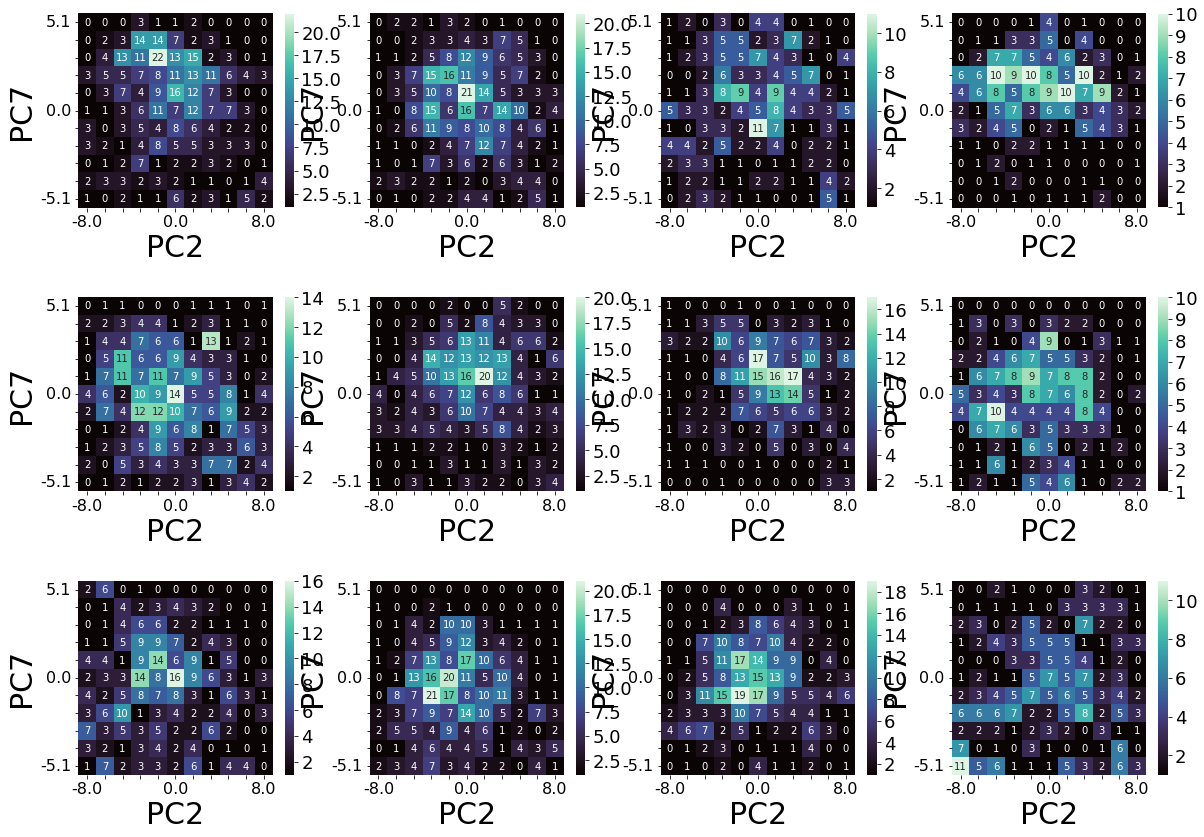

In [13]:
################ PLOT THE COUNTS OF THE BINS #############

CoRo = math.ceil(math.sqrt(len(rawtransdf.CellID.unique())))
fig, axes = plt.subplots(CoRo, CoRo, figsize=(5*CoRo,5*CoRo))#, sharex=True)


#make numpy array with heatmap data
bighm = np.zeros((len(rawtransdf.CellID.unique()),nbins,nbins))
for i,(t, mdf) in enumerate(rawtransdf.groupby('CellID')):
    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[i,y,x] = 0
            else:
                bighm[i,y,x] = len(current)            

for i, ax in enumerate(axes.flatten()):
    if i<len(rawtransdf.CellID.unique()):            
        #plot heatmap with seaborn
        ax = sns.heatmap(
            bighm[i],
            vmin=np.min(bighm[i][np.nonzero(bighm[i])]),
            vmax=bighm[i].max(), #center=0,
            cmap='mako',#sns.light_palette('#004a27', as_cmap=True),
            square=True,
            xticklabels = True,
            yticklabels = True,
            annot = True,
            fmt = '.0f',
            ax = ax,
            cbar_kws={'shrink': 0.82}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers[f'PC{whichpcs[0]}'].to_list()],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers[f'PC{whichpcs[1]}'].to_list()],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for i, l in enumerate(ax.xaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        for i, l in enumerate(ax.yaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel(f'PC{whichpcs[0]}', fontsize = 30)
        ax.set_ylabel(f'PC{whichpcs[1]}', fontsize = 30)
        # adjust colorbar tick label size
        cbar = ax.collections[0].colorbar
        cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
        #correct axis orientations
        ax.invert_yaxis()
        # #set title
        # ax.set_title('Probability Density (sec)', fontsize = 22)
    else:
        ax.remove()
plt.savefig(savedir + f'PC{whichpcs[0]}-PC{whichpcs[1]} cell count heatmap separated.png', bbox_inches='tight')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


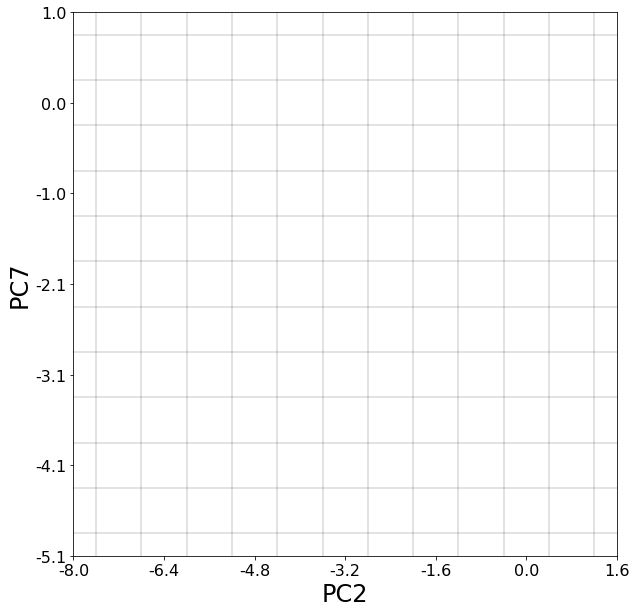

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


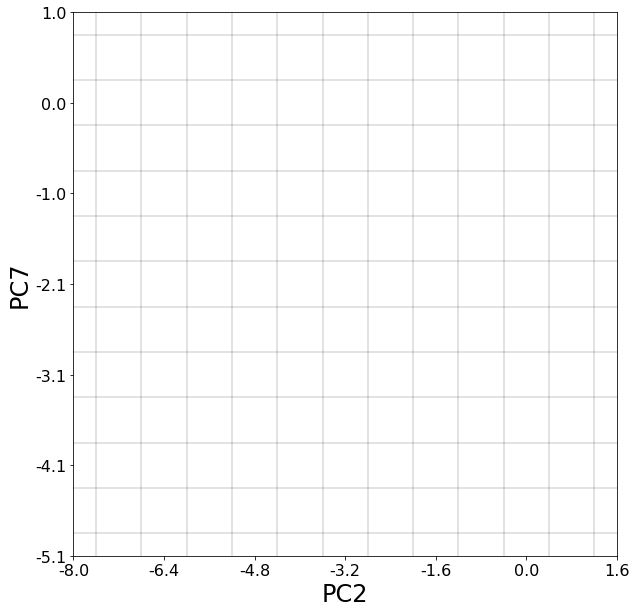

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


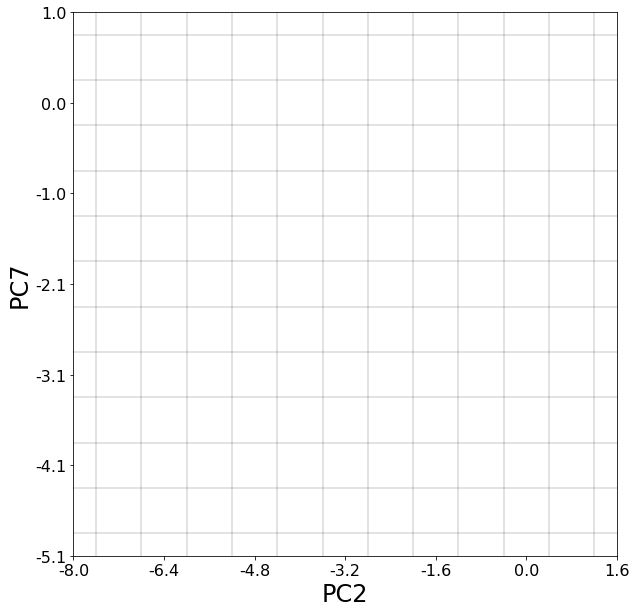

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


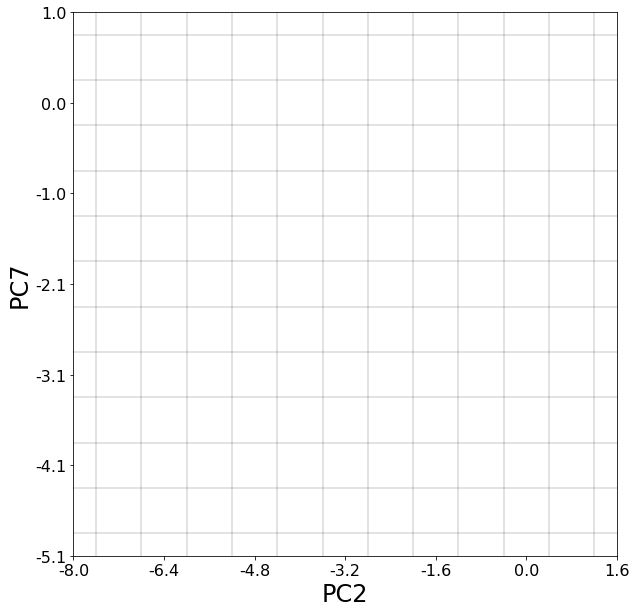

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


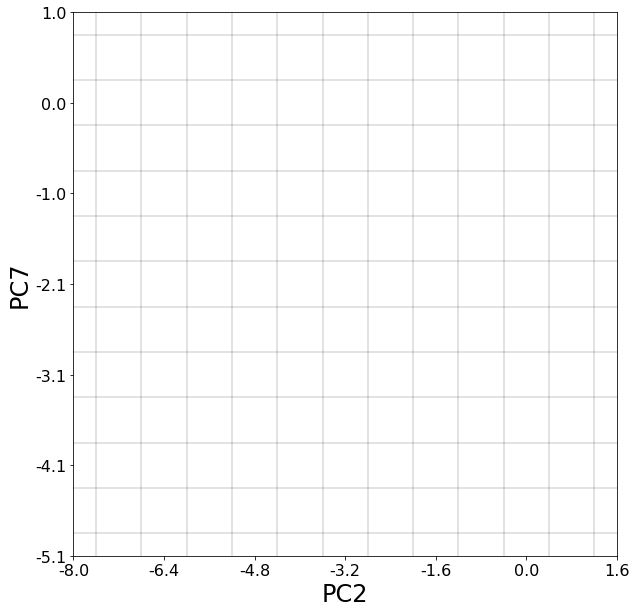

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


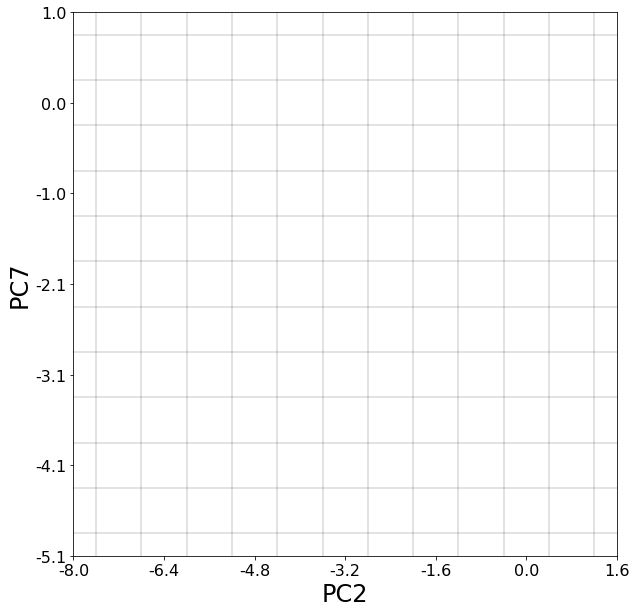

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


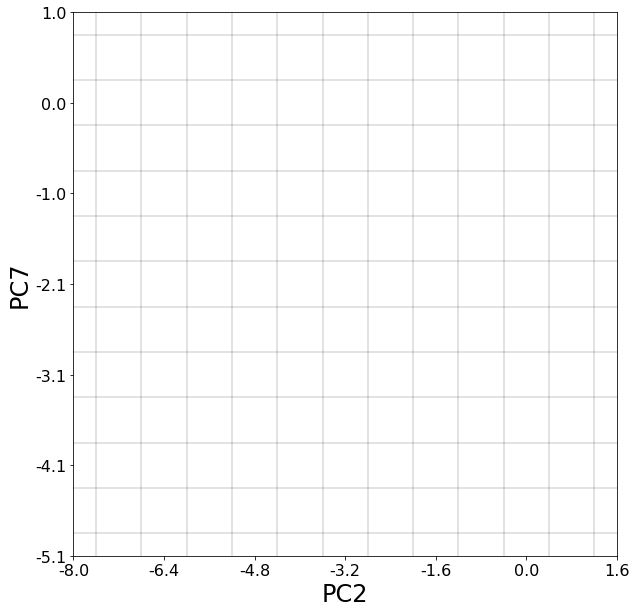

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


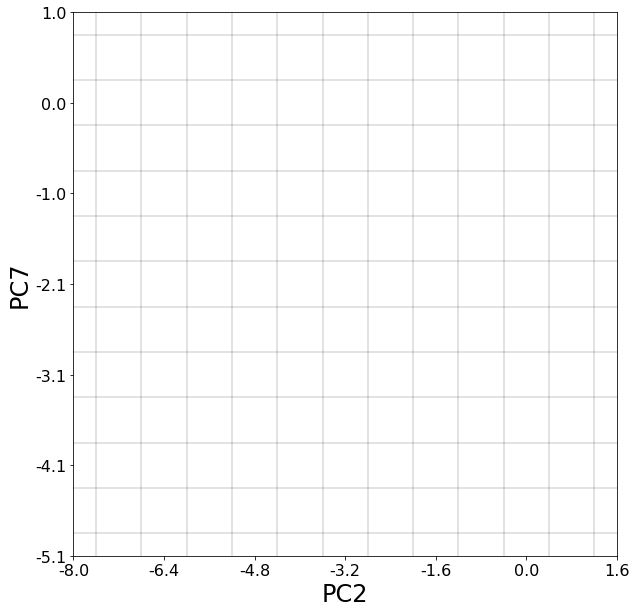

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


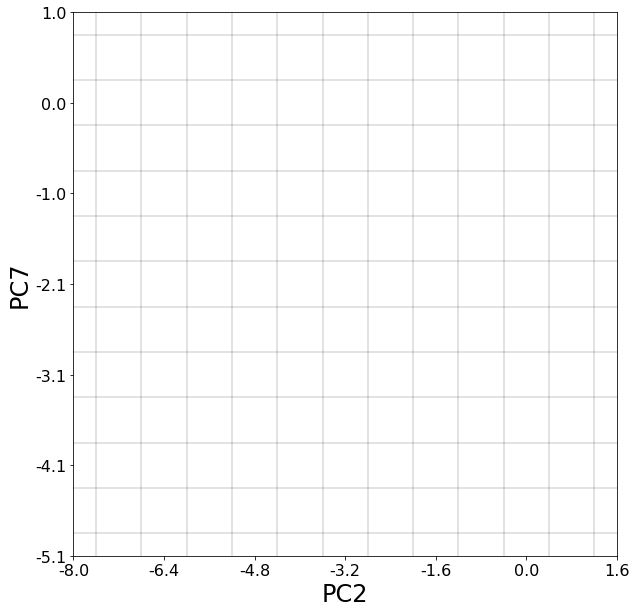

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


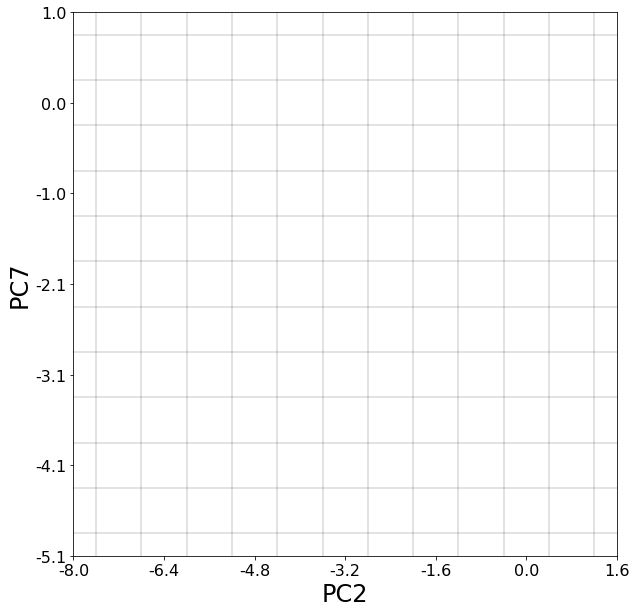

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


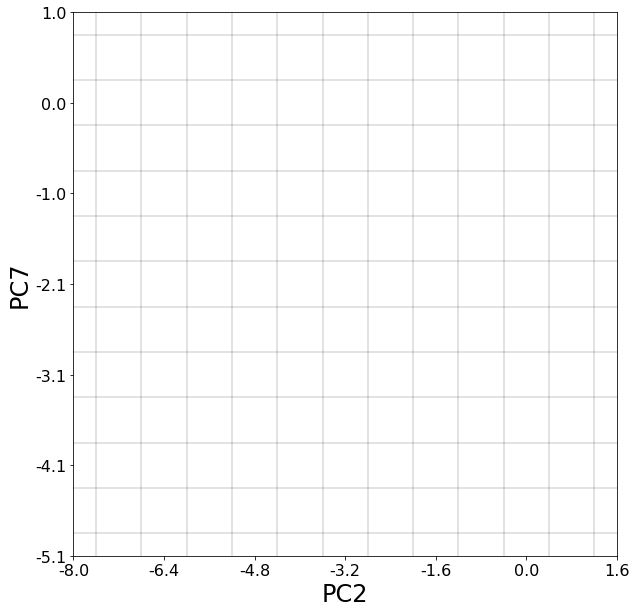

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


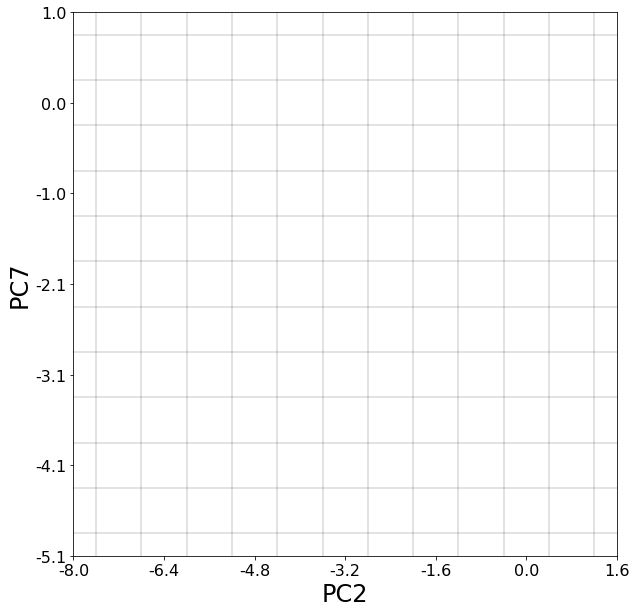

In [20]:
############# MAKE VIDEOS OF THE TRAJECTORIES #################
from CustomFunctions.PCvisualization import interpolate_transitions_by_distance
from cmocean import cm
from matplotlib.animation import FuncAnimation 

singlecelldir = Path(savedir,'singlecells')

norm = matplotlib.colors.Normalize()
cmm = cm.dense


for cn, cells in TotalFrame.groupby('CellID'):
    cells = cells.sort_values('time').reset_index(drop = True)

    #get the interpolated points just in case I haven't calculated them yet
    bintraj = cells[[f'PC{whichpcs[0]}bins',f'PC{whichpcs[1]}bins']].to_numpy()


    #interpolate the trajectory in the transition space
    interarray = interpolate_transitions_by_distance(bintraj, 0.01)

    #make fig
    fig, ax = plt.subplots(figsize = (10,10))


    #add "grid lines" first 
    for h in np.linspace(0.5, nbins+0.5, nbins+1):
        ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
        ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines




    ax.set_aspect("equal")
    ax.set_xlabel(f'PC{whichpcs[0]}', fontsize = 24)
    ax.set_ylabel(f'PC{whichpcs[1]}', fontsize = 24)
    ax.set_xticklabels([round(x,1) for x in centers[f'PC{whichpcs[0]}'].to_list()], fontsize = 16)
    ax.set_yticklabels([round(x,1) for x in centers[f'PC{whichpcs[1]}'].to_list()], fontsize = 16)
    ax.set_xlim(0,nbins+1)
    ax.set_ylim(0,nbins+1)
    # ax.set_title(mm, fontsize = 30)


    #normalize to the colors to the length of the trajectory
    norm.autoscale([0,interarray[:,1].max()])

    # create a point in the axes
    # point, = ax.plot([],[])#, marker="o", color = '#eb4034', markersize = 15)
    # scat = ax.scatter(interarray[:,2], interarray[:,3], color = cmm(norm(interarray[:,1])), edgecolor='none')
    scat = ax.scatter(np.empty(len(interarray)), np.empty(len(interarray)), color = cmm(norm(interarray[:,1])), edgecolor='none')




    # make function for updating point position
    def animate(i, interarray):
        current = interarray.copy()
        #set the colors to the correct set
        scat.set_facecolor(cmm(norm(current[:,1])))
        #remove the datapoints that are in "the future"
        current[np.where(current[:,0]>(i-1))] = np.nan
        #set the current set of data
        scat.set_offsets(current[:,[2,3]])

        return scat,

    #add two to the frame count to adjust the range function and to add a blank frame at the beginning
    ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                        frames=list(range(int(max(interarray[:,0])+2))), fargs = (interarray,))
    plt.show()

    #make the directory to save this combined image
    specificdir = singlecelldir / cn
    if not os.path.exists(specificdir):
        os.makedirs(specificdir)
    savename = str(specificdir / f'{cn}_plotanimation_PC1-PC7colorchange.mp4')
    ani.save(savename, fps=8, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [16]:
savename = specificdir / f'{cn}_plotanimation_PC1-PC7colorchange.mp4'
savename.

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator


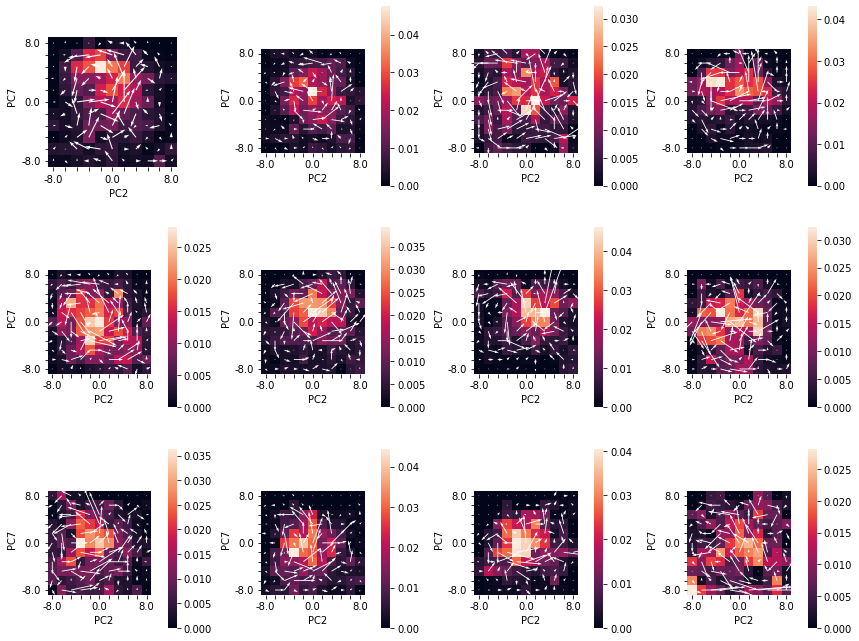

In [20]:
########### PDFs AND PROBABILITY FLUX OF THE SEPARATED CellIDs #############
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords
# inverse scale for arrows
scale = 0.001


# combine error data with real transition data
elldf = trans_rate_df_sep.copy()

CoRo = math.ceil(math.sqrt(len(elldf.CellID.unique())))
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3*CoRo,3*CoRo))#, sharex=True)
#single colorbar axis
# cbar_ax = fig.add_axes([.98, .2, .015, .5])
################ heatmap of probability density #############
bighm = np.zeros((len(transdf.CellID.unique()),nbins,nbins))
for i,(t, mdf) in enumerate(transdf.groupby('CellID')):
    #get total time observed in the system
    ttot = mdf.time_elapsed.sum()
    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[i,y,x] = 0
            else:
                bighm[i,y,x] = current.time_elapsed.sum()/ttot

for i, ax in enumerate(axes.flatten()):
    if i<len(transdf.CellID.unique()):
        #plot heatmap with seaborn
        sns.heatmap(
            bighm[i],
            vmin=0, vmax=bighm[i].max(), #center=0,
            cmap='rocket',
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
#             cbar=i==0,
            cbar_ax = None if i else cbar_ax,
    #         cbar_kws=cbar_kws
        )

        ######################### vector map of probability flux ################
        mm = elldf.CellID.unique()[i]
        mdf = elldf[elldf.CellID==mm]


    #     for x in range(1,nbins+1):
    #         for y in range(1,nbins+1):
    #             current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
    #             xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
    #             ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

    #             ell = Ellipse(xy=(x-0.5+(xcurrent.values*(1/scale)),y-0.5+(ycurrent.values*(1/scale))),
    #                     width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
    #                       height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
    #                     angle=np.arctan2(current.evec1y,current.evec1x),
    #                      color = 'lightblue')
    #             ax.add_artist(ell)
    #             ell.set_alpha(0.2)


        for x in range(1,nbins+1):
            for y in range(1,nbins+1):
                current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
                xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
                ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
                ax.quiver(x-0.5,
                           y-0.5, 
                           xcurrent,
                           ycurrent,
                          angles = 'xy',
                          scale_units = 'xy',
                          scale = scale,
    #                       width = 0.012,
    #                       minlength = 0.8,
                          color = 'white')



        # axis label stuff
        ax.set_xlabel('PC2')#, fontsize = 45)
        ax.set_ylabel('PC7')#, fontsize = 45)
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
#             fontsize = 16
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
#             fontsize = 16
        )
        #take out all axis labels except the desired ones
        for i, l in enumerate(ax.xaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        for i, l in enumerate(ax.yaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        ax.set_xlim(0,nbins+1)
        ax.set_ylim(0,nbins+1)
#         ax.set_title(mm, fontsize = 45, loc = 'center',pad = -100)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
# axes[0].set_ylabel('PC7', fontsize = 45)
    


# ########## add scale for the vectors ##########
# #legend background
# lxp = 9.125
# lyp = 0.125
# rect = Rectangle((lxp, lyp), 1.8, 1.8, linewidth=1, edgecolor='black', facecolor='#80858a')
# axes[0].add_patch(rect)
# rect.set_zorder(4 * 5)
# #x-axis legend arrow
# axes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
# #x-axis legend text
# xsc = f'{(np.diff(centers.PC2).mean()/time_interval)*scale:.1e}'
# xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
# axes[0].text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
# #y-axis legend arrow
# axes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
# #y-axis legend text
# ysc = f'{(np.diff(centers.PC7).mean()/time_interval)*scale:.1e}'
# ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
# axes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
    


plt.tight_layout()
plt.savefig(savedir + 'PC2_PC7 probability flux and pdf separated.png', bbox_inches='tight')


In [7]:
############## bootstrapped AERs #################


xyscaling = [centers[f'PC{whichpcs[0]}'].diff().mean(),centers[f'PC{whichpcs[1]}'].diff().mean()]
center = [5,6]

if os.path.exists(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_Area_Enclosing_Rates.csv'):
    af = pd.read_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_Area_Enclosing_Rates.csv', index_col=0)
    af = af.sort_values(by='CellID')
    print('Opened aers')
else:
    
    results = []
    for i, cells in rawtransdf.groupby('CellID'):
        cell = cells.sort_values('cumulative_time').reset_index(drop = True)
        results.append(DetailedBalance.get_area_enclosing_rate(
            cell,
            nbins,
            xyscaling,
            center,
            ))


    af = pd.concat(results).reset_index(drop=True)
    af['aercumsum'] = af.groupby('CellID').aer.transform('cumsum')
    af['avcumsum'] = af.groupby('CellID').angular_velocity.transform('cumsum')
    af.to_csv(savedir+f'PC{whichpcs[0]}-PC{whichpcs[1]}_Area_Enclosing_Rates.csv')

Opened aers


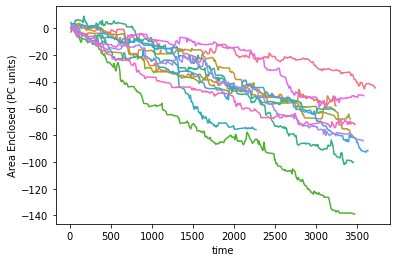

In [5]:
sns.lineplot(data=af,x='time',y='aercumsum', hue = 'CellID', legend = False)
plt.ylabel('Area Enclosed (PC units)')
plt.savefig(savedir + 'aer over time.png', bbox_inches='tight')#, dpi=500)

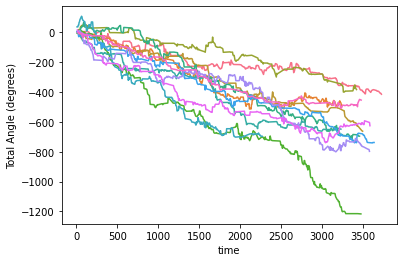

In [6]:
sns.lineplot(data=af,x='time',y='avcumsum', hue = 'CellID', legend = False)
plt.ylabel('Total Angle (degrees)')
plt.savefig(savedir + 'angle over time.png', bbox_inches='tight')#, dpi=500)

In [8]:
for c, cell in af.groupby('CellID'):
    x = cell.time
    y = cell.avcumsum
    m, b = np.polyfit(x,y,1)
#     print(coef)
    print(f'The cycling frequency of {c} is {m} and the average cycle time is {360/m/60} minutes')
    
#     poly1d_fn = np.poly1d(coef) 

The cycling frequency of 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_01 is -0.0995767293369746 and the average cycle time is -60.255041915421636 minutes
The cycling frequency of 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_01 is -0.1699264690044142 and the average cycle time is -35.309390203618825 minutes
The cycling frequency of 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_01 is -0.18241082045975787 and the average cycle time is -32.89278555338594 minutes
The cycling frequency of 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_01 is -0.12335834912452472 and the average cycle time is -48.6387832082875 minutes
The cycling frequency of 20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01 is -0.32314588436096686 and the average cycle time is -18.567465316370114 minutes
The cycling frequency of 20240524_488_EGFP-CAAX_640_actin-halotag_cell2_01 is -0.24513743355131556 and the average cycle time is -24.47606598909749 minutes
The cycling frequency of 20240524_488_EGFP-CAAX_

In [9]:
for c, cell in af.groupby('CellID'):
    print(f'The cycling frequency of {c} is {cell.angular_velocity.mean()} and the average cycle time is {360/cell.angular_velocity.mean()/60} minutes')
    

The cycling frequency of 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_01 is -0.8782459622973319 and the average cycle time is -6.831799128691796 minutes
The cycling frequency of 20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_01 is -0.9660900942353516 and the average cycle time is -6.210600890954095 minutes
The cycling frequency of 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2_01 is -2.1113170229597977 and the average cycle time is -2.841828079228369 minutes
The cycling frequency of 20240523_488_EGFP-CAAX_561_mysoin-mApple_37C_cell3_01 is -1.2925933240117902 and the average cycle time is -4.641831184287683 minutes
The cycling frequency of 20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01 is -2.5618450671221247 and the average cycle time is -2.3420620071845963 minutes
The cycling frequency of 20240524_488_EGFP-CAAX_640_actin-halotag_cell2_01 is -1.500208597138362 and the average cycle time is -3.999443818309641 minutes
The cycling frequency of 20240524_488_EGFP-CAAX_640_ac

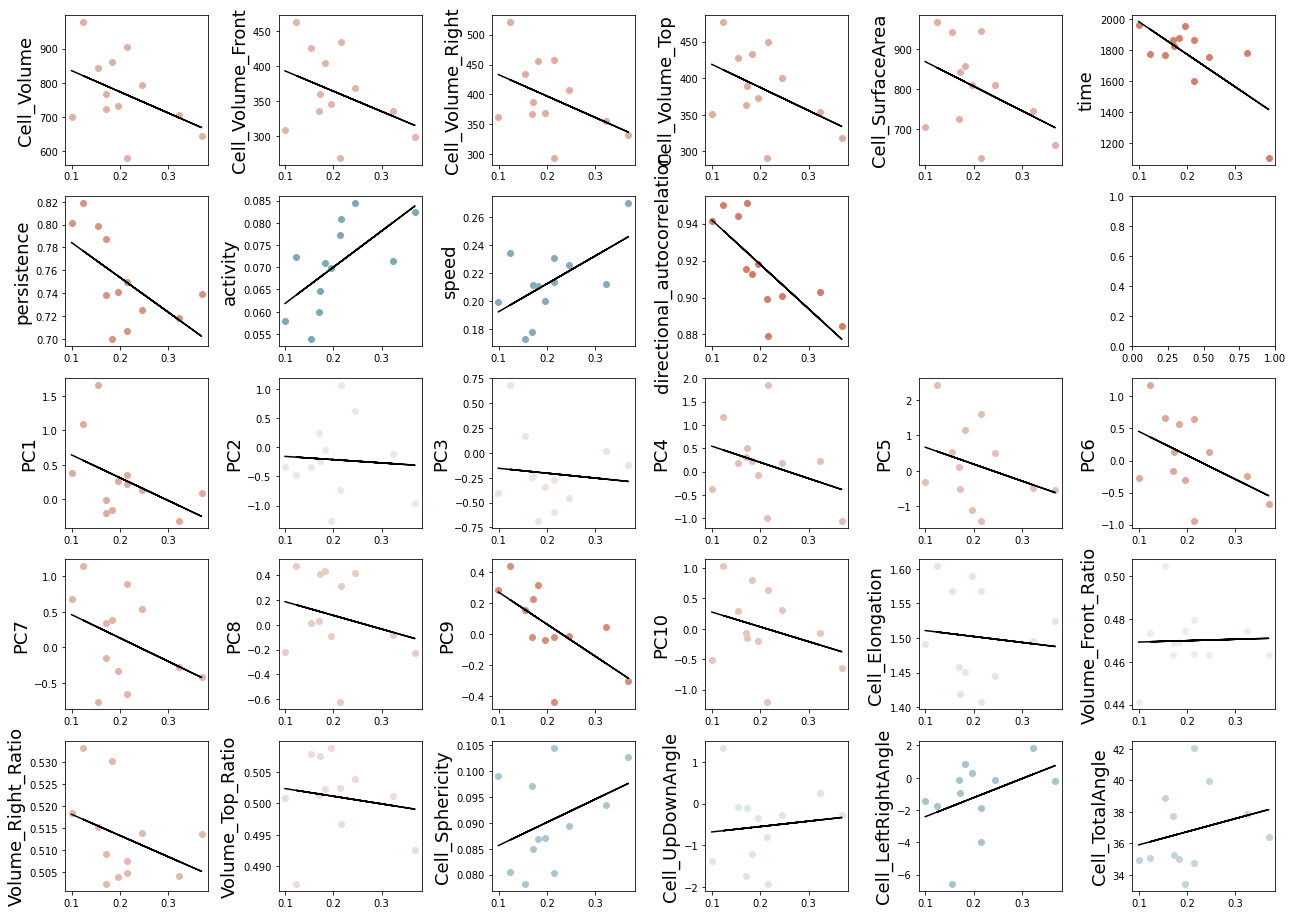

In [8]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable


def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})


new_remove = []
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'bins' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'angles' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['frame','cellnumber','structure','Date','Experiment','x','y','z','OriginaltoReconError',
                   'RecontoOriginalError', 'Width_Rotation_Angle','cell','Treatment'])
dropframe = TotalFrame.drop(columns=new_remove)


sp = math.ceil(math.sqrt(len(dropframe.columns.to_list())))
fig, axes = plt.subplots(sp,sp,figsize=(sp*3,sp*2.5))

#get the slopes of all of the individual cells
slopelist = []
for i, cell in af.groupby('CellID'):
    cell = cell.sort_values('time').reset_index(drop = True)
    m,b = np.polyfit(cell.time,cell.avcumsum,1)
    slopelist.append([i,abs(m)])
slopeframe = pd.DataFrame(slopelist, columns = ['CellID','slope'])
avgs = TotalFrame.groupby('CellID').mean()
slopeframe = slopeframe.merge(avgs.reset_index(), left_on='CellID', right_on='CellID')
slopecorr = slopeframe.corr()

axes = axes.flatten()
for i, c in enumerate(dropframe):
    if c == 'CellID':
        ax.remove()
    elif i<len(dropframe.columns.to_list()):
        ax = axes[i]
        x = slopeframe['slope']
        y = slopeframe[c]
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = slopecorr.loc['slope', c]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
        ax.set_ylabel(c, fontsize = 18)
    else:
        ax.remove()

for a in range(i+1, len(axes)):
    axes[a].remove()
        
plt.tight_layout()

        
# # [ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes)];
# labelz = ['Speed\n(µm/sec)','Persistence\n(a.u.)','Turn Angle (°)','Directional Autocorrelation (a.u.)']
# [ax.set_xlabel(labelz[i], rotation=35, horizontalalignment='center', fontsize = 20) for i, ax in enumerate(axes)];

        
# plt.tight_layout()
plt.savefig(savedir + 'angular velocity vs. behavior scatter matrix.png', bbox_inches='tight')#, dpi=500)

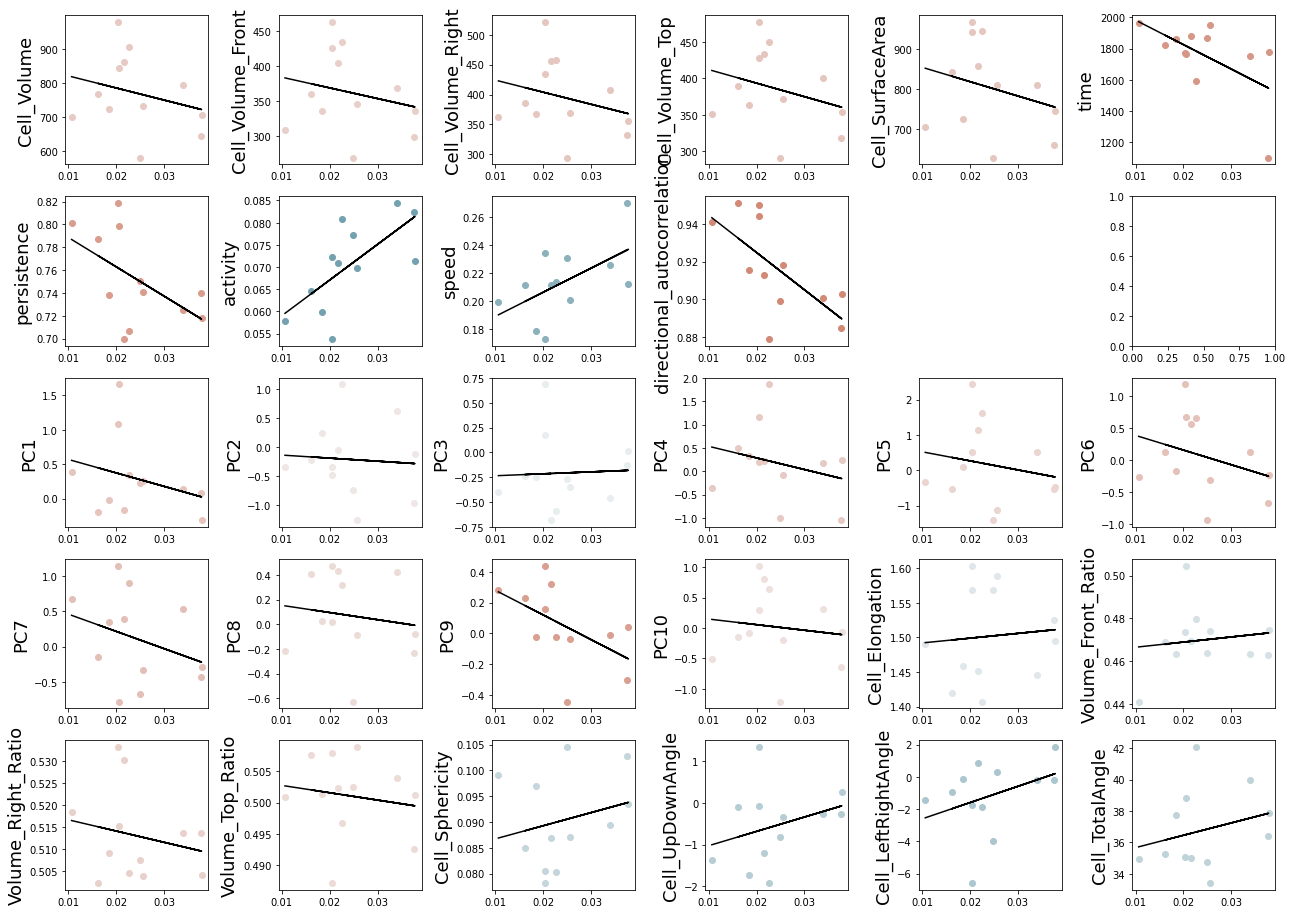

In [140]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable


def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})


new_remove = []
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'bins' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'Axis' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'Trajectory' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'angles' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'intensity' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'raw' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in TotalFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['frame','cellnumber','structure','Date','Experiment','x','y','z','OriginaltoReconError',
                   'RecontoOriginalError', 'Width_Rotation_Angle','cell','Treatment'])
dropframe = TotalFrame.drop(columns=new_remove)


sp = math.ceil(math.sqrt(len(dropframe.columns.to_list())))
fig, axes = plt.subplots(sp,sp,figsize=(sp*3,sp*2.5))

#get the slopes of all of the individual cells
slopelist = []
for i, cell in af.groupby('CellID'):
    cell = cell.sort_values('time').reset_index(drop = True)
    m,b = np.polyfit(cell.time,cell.aercumsum,1)
    slopelist.append([i,abs(m)])
slopeframe = pd.DataFrame(slopelist, columns = ['CellID','slope'])
avgs = TotalFrame.groupby('CellID').mean()
slopeframe = slopeframe.merge(avgs.reset_index(), left_on='CellID', right_on='CellID')
slopecorr = slopeframe.corr()

axes = axes.flatten()
for i, c in enumerate(dropframe):
    if c == 'CellID':
        ax.remove()
    elif i<len(dropframe.columns.to_list()):
        ax = axes[i]
        x = slopeframe['slope']
        y = slopeframe[c]
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = slopecorr.loc['slope', c]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
        ax.set_ylabel(c, fontsize = 18)
    else:
        ax.remove()

for a in range(i+1, len(axes)):
    axes[a].remove()
        
plt.tight_layout()

        
# # [ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes)];
# labelz = ['Speed\n(µm/sec)','Persistence\n(a.u.)','Turn Angle (°)','Directional Autocorrelation (a.u.)']
# [ax.set_xlabel(labelz[i], rotation=35, horizontalalignment='center', fontsize = 20) for i, ax in enumerate(axes)];

        
# plt.tight_layout()
plt.savefig(savedir + 'aer vs. behavior scatter matrix.png', bbox_inches='tight')#, dpi=500)

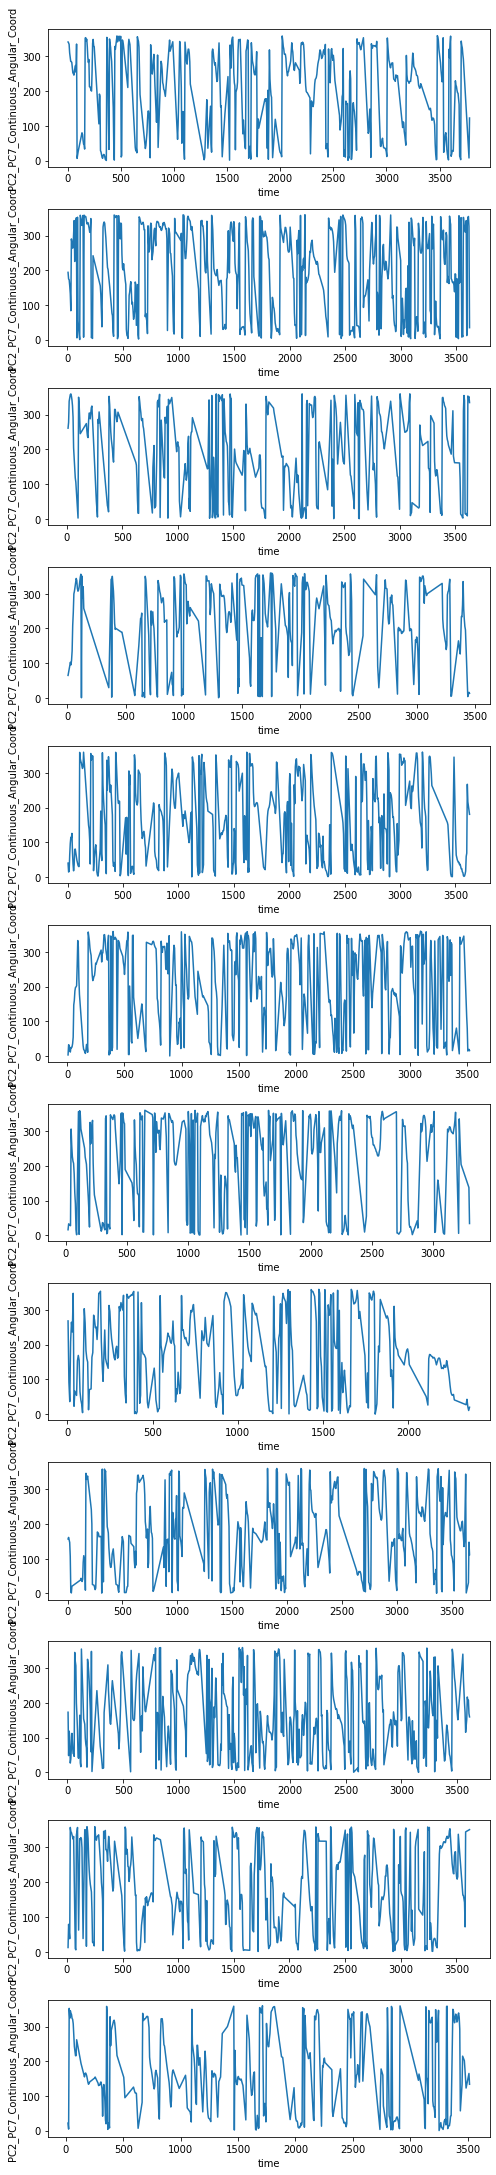

In [311]:
################## ANGULAR POSITION THROUGH TIME #####################

origin = [5, 6]
whichpcs = [2,7]
binrange = 10
direction = 'counterclockwise'
#get angular coordinates
angframe = linear_cycle_utils.linearize_cycle_continuous(
            TotalFrame, 
            centers,
            origin, 
            whichpcs,  
            binrange, 
            direction,)
fig, axes = plt.subplots(len(angframe.CellID.unique()), 1, figsize=(7,30))
for i,(c, cell) in enumerate(angframe.groupby('CellID')):
    ax = axes[i]
    cell = cell.sort_values('time').reset_index(drop=True)
    sns.lineplot(data=cell,x='time',y=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord', ax=ax)
plt.tight_layout()


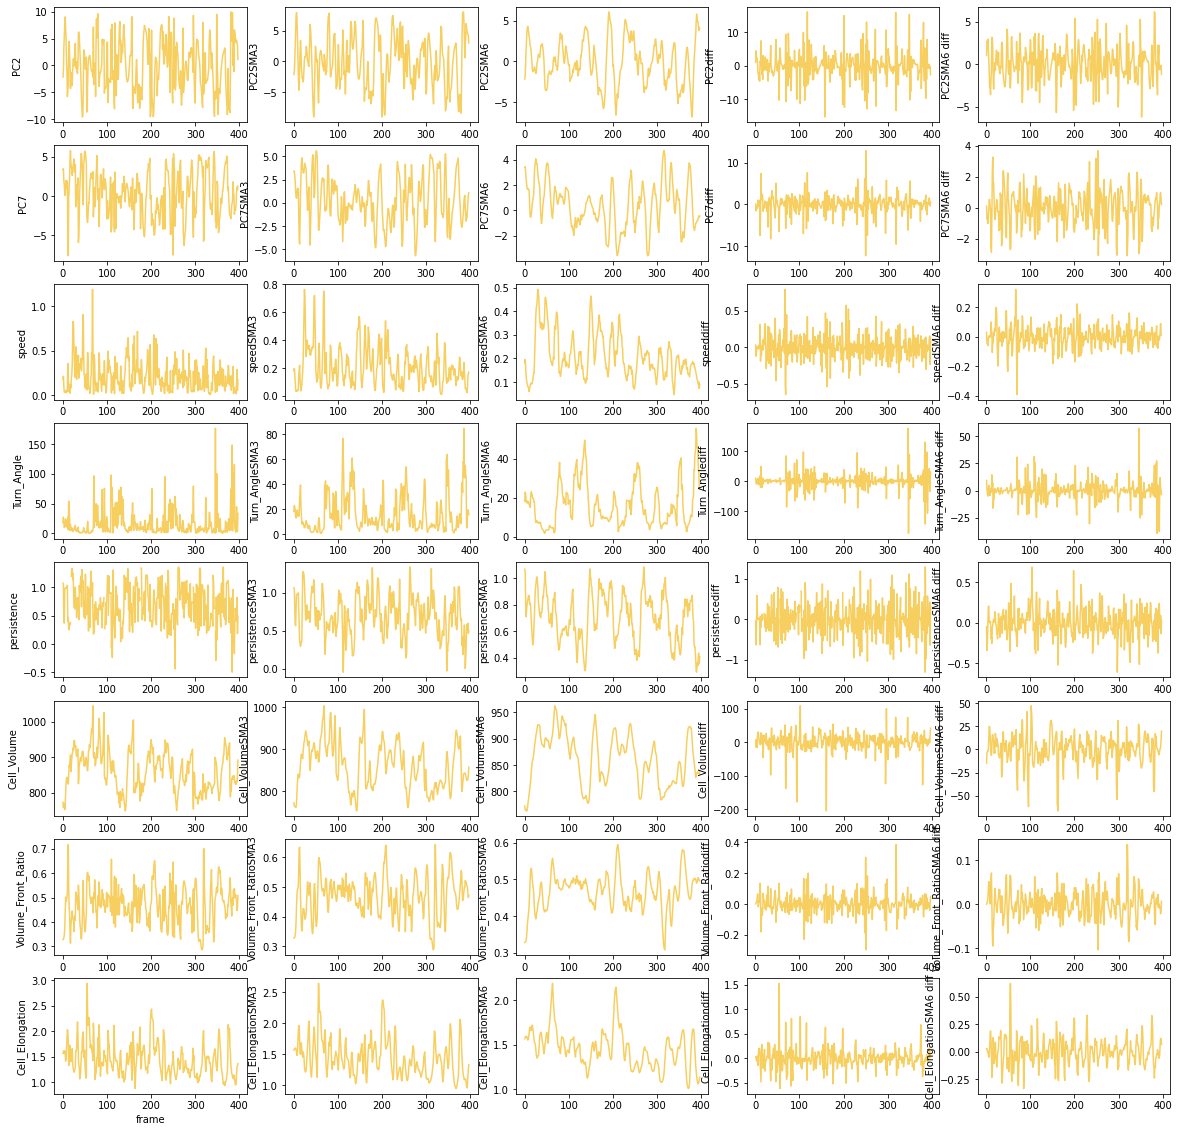

In [26]:
############# Plot a bunch of metrics over time ################
#add diff of PC1_PC2_cumulative_area_explored for rolling sum measure


data = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[2]]
data = data.sort_values('time').reset_index(drop = True)


metlist = [
    'PC2',
    'PC7',
    'speed',
    'Turn_Angle',
    'persistence',
    'Cell_Volume',
    'Volume_Front_Ratio',
    'Cell_Elongation',
]

fig, axes = plt.subplots(len(metlist),5,figsize=(20,len(metlist)*2.5))
for a, ax in enumerate(axes):
    #plot metric in question
    
    ax[0].plot(data[metlist[a]].to_numpy(), color = '#f7cf60')
    ax[0].set_ylabel(metlist[a])#, color='#f7cf60')
    
    ax[1].plot(data[metlist[a]].rolling(3,min_periods=1).mean().to_numpy(), color = '#f7cf60')
    ax[1].set_ylabel(metlist[a]+'SMA3')#, color='#f7cf60')
    
    ax[2].plot(data[metlist[a]].rolling(10,min_periods=1).mean().to_numpy(), color = '#f7cf60')
    ax[2].set_ylabel(metlist[a]+'SMA6')#, color='#f7cf60')
    
    ax[3].plot(data[metlist[a]].diff().to_numpy(), color = '#f7cf60')
    ax[3].set_ylabel(metlist[a]+'diff')#, color='#f7cf60')
    
    ax[4].plot(data[metlist[a]].diff().rolling(3,min_periods=1).mean().to_numpy(), color = '#f7cf60')
    ax[4].set_ylabel(metlist[a]+'SMA6 diff')#, color='#f7cf60')
    
    
    if a == len(axes)-1:
        ax[0].set_xlabel('frame')
        

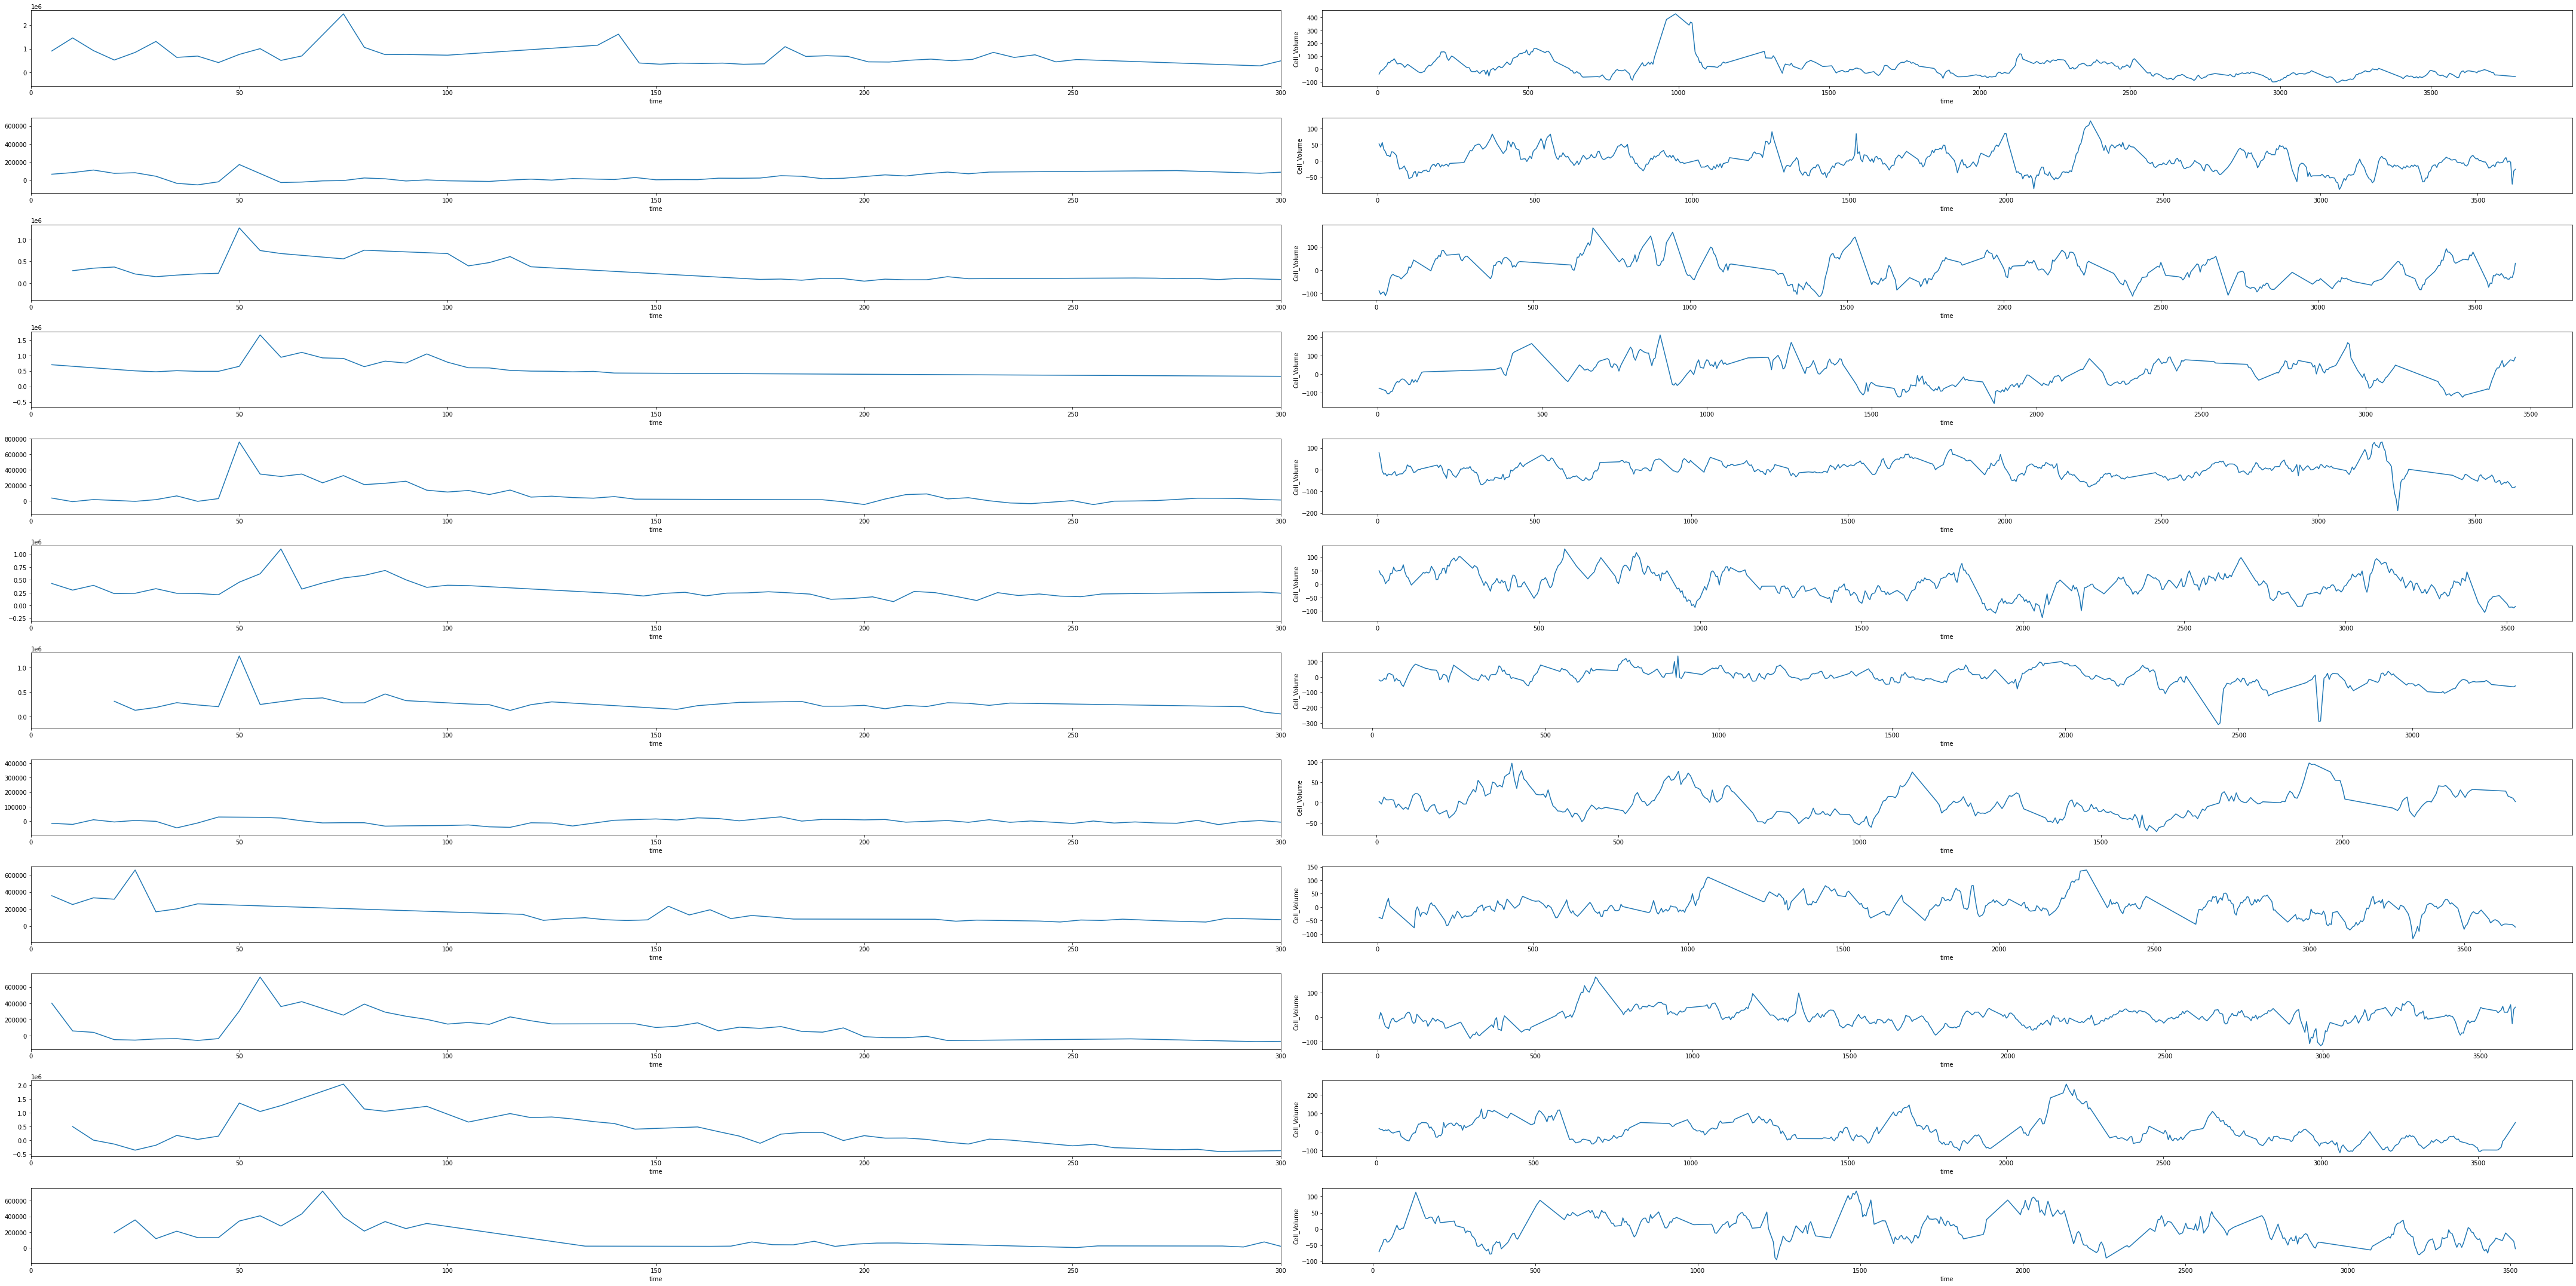

In [16]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]


statlist = ['PC2','PC7','Cell_Elongation','Cell_Volume']
sts = statlist[3]
fig, axes = plt.subplots(len(TotalFrame.CellID.unique()), 2, figsize=(60,30))
for i, (d, dat) in enumerate(TotalFrame.groupby('CellID')):
    ax = axes[i]
    x = dat[sts]
    zerod = x - x.mean()
    y = autocorr(zerod)
    sns.lineplot(data = dat, x='time',y=y,ax=ax[0])
    sns.lineplot(data = dat, x = 'time',y=zerod,ax=ax[1])
    ax[0].set_xlim(0,300)
plt.tight_layout()

plt.savefig(savedir+sts+' autocorrelation and actual.png')

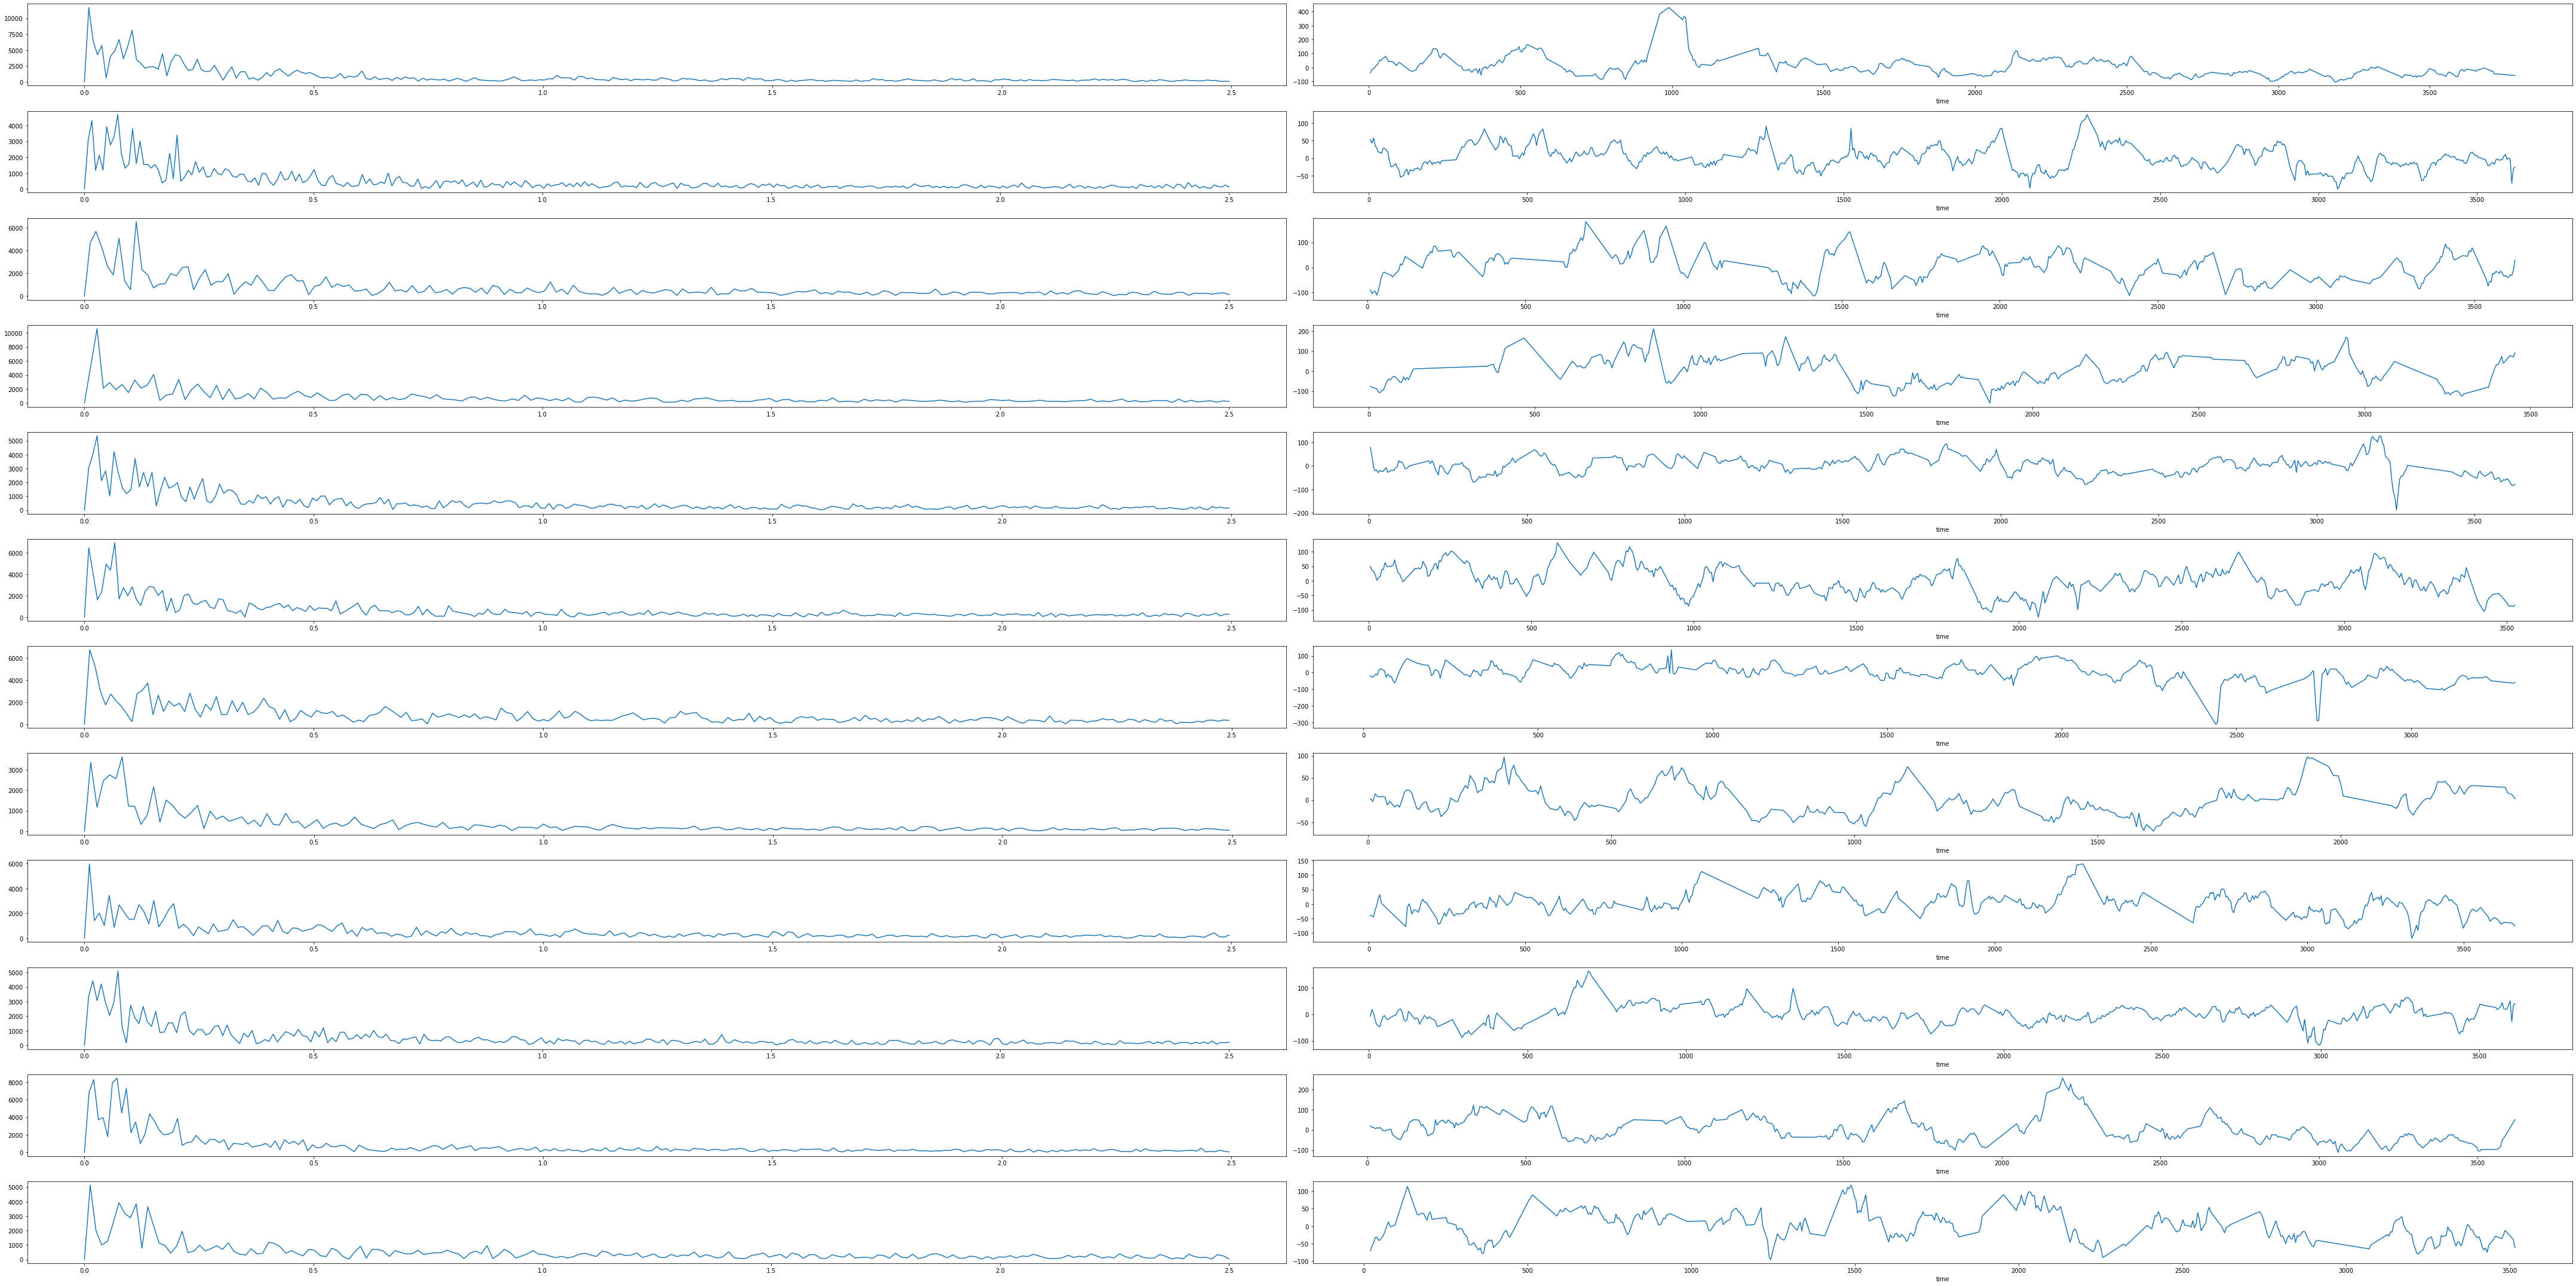

In [6]:
from scipy import fft
statlist = ['PC2','PC7','Cell_Elongation','Cell_Volume']
sts = statlist[3]
fig, axes = plt.subplots(len(TotalFrame.CellID.unique()), 2, figsize=(60,30))
for i, (d, dat) in enumerate(TotalFrame.groupby('CellID')):
    ax = axes[i]
    cell = dat.sort_values('time').reset_index()
    N = len(cell)
    norm = cell[sts].values - cell[sts].mean()
    yf = fft.rfft(norm)
    xf = fft.rfftfreq(N,1/5)
    ax[0].plot(xf, np.abs(yf))
    sns.lineplot(data = cell, x = 'time',y=norm,ax=ax[1])
plt.tight_layout()

plt.savefig(savedir+sts+' FFT and actual.png')


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


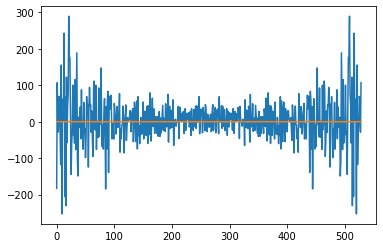

In [12]:
plt.plot(fft(data.PC2.values))
plt.plot(fftfreq(len(data.PC2.values),5))

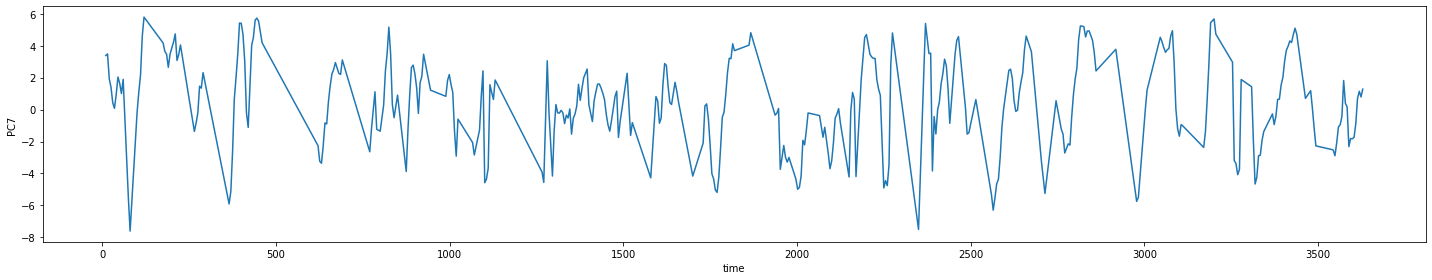

In [154]:
data = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[2]]
data = data.sort_values('time').reset_index(drop = True)
fix, ax = plt.subplots(1,1,figsize=(20,4))
sns.lineplot(data = data, x = 'time',y='PC7', ax = ax)
plt.tight_layout()

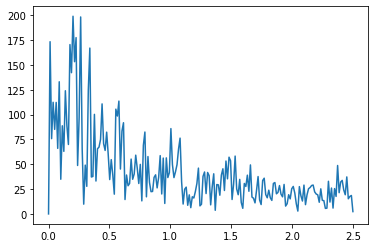

In [151]:
data = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[2]]
data = data.sort_values('time').reset_index(drop = True)
N = len(data.PC7.values)
norm = data.PC7.values - data.PC7.mean()
yf = fft.rfft(norm)
xf = fft.rfftfreq(N,1/5)
plt.plot(xf, np.abs(yf))

<AxesSubplot:xlabel='time'>

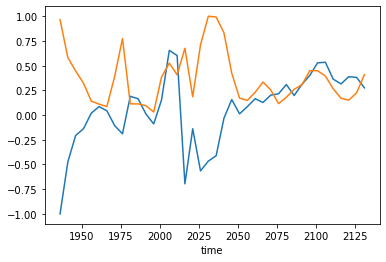

In [123]:
cells = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[4]]
cells = cells.sort_values('time').reset_index(drop = True)
diff = cells.time.diff()
difflist = [0]
difflist.extend(diff[diff>5].index.to_list())
runs = []
for x in range(len(difflist)-1):
    runs.append(list(range(difflist[x], difflist[x+1])))
cells = cells.iloc[max(runs,key=len)]
pc = cells.PC7.values/abs(cells.PC7).max()
elong = cells.Cell_TotalAngle.values/abs(cells.Cell_TotalAngle).max()
x = cells.x.diff().values/abs(cells.x.diff()).max()
y = cells.y.diff().values/abs(cells.y.diff()).max()
z = cells.z.diff().values/abs(cells.z.diff()).max()
sns.lineplot(data = cells, x='time',y=pc)
sns.lineplot(data = cells, x='time',y=elong)
# sns.lineplot(data = cells, x='time',y=x)
# sns.lineplot(data = cells, x='time',y=y)
# sns.lineplot(data = cells, x='time',y=z)
# plt.xlim(1500,2000)

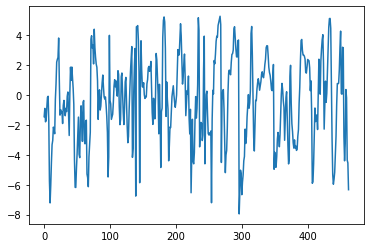

In [124]:
plt.plot(data.PC7)

In [98]:
avglist = []

# for i, cells in TotalFrame.groupby('CellID'):
cells = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[5]]
cells = cells.sort_values('time').reset_index(drop = True)
diff = cells.time.diff()
difflist = [0]
difflist.extend(diff[diff>5].index.to_list())
runs = []
for x in range(len(difflist)-1):
    runs.append(list(range(difflist[x], difflist[x+1])))
#start with time zero
timeadd = 0
rawtimeadd = 0
for r in runs:
    r = np.array(r, dtype=int)
    #skip runs less than 3 frames long
    if len(r)>=13:
        cell = cells.iloc[r]
        print(cell.PC2.diff())

0          NaN
1    -2.527284
2     0.830749
3    -0.240370
4     1.119241
5    -0.427232
6    -0.976530
7    -3.965934
8    -2.403207
9    -1.364356
10   -3.426015
11   -2.148928
12   -0.876641
13    0.347664
14    0.544703
15    0.988935
16    3.328443
17    1.535309
18   -0.205391
19   -2.486091
20   -0.047132
Name: PC2, dtype: float64
21         NaN
22    1.736701
23    0.845072
24    1.121018
25    1.598027
26   -0.294734
27   -0.219335
28   -0.865696
29   -1.367974
30   -2.686210
31   -0.411156
32    0.470224
33   -0.494535
34   -1.004707
35   -0.966627
36   -2.151993
37   -2.670760
38   -0.937540
39    0.688013
40    0.710483
41    0.355998
42    1.071905
43    1.137390
44   -0.250732
45    0.448306
Name: PC2, dtype: float64
56         NaN
57    2.043276
58    2.249299
59   -0.033215
60   -0.995628
61   -1.291784
62    7.544786
63   -1.556401
64   -3.770292
65    2.206461
66    0.263224
67   -0.031455
68   -0.264018
69    0.379508
70    1.122605
71   -0.187175
72   -5.152437
73 

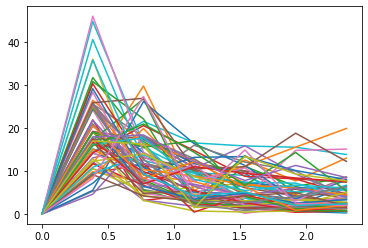

In [143]:
avglist = []
for cn in range(5):
    # for i, cells in TotalFrame.groupby('CellID'):
    cells = TotalFrame[TotalFrame.CellID == TotalFrame.CellID.unique()[cn]]
    cells = cells.sort_values('time').reset_index(drop = True)
    diff = cells.time.diff()
    difflist = [0]
    difflist.extend(diff[diff>5].index.to_list())
    runs = []
    for x in range(len(difflist)-1):
        runs.append(list(range(difflist[x], difflist[x+1])))
    #start with time zero
    timeadd = 0
    rawtimeadd = 0
    for r in runs:
        r = np.array(r, dtype=int)
        #skip runs less than 3 frames long
        if len(r)>=13:
            cell = cells.iloc[r[:13]]
            N = len(cell)
            norm = cell.PC2.values - cell.PC2.mean()
            yf = fft.rfft(norm)
            xf = fft.rfftfreq(N,1/5)
            plt.plot(xf, np.abs(yf))
    #         avglist.append(abs(yf))
    # plt.plot(xf, np.mean(np.array(avglist).T, axis = 1))
    plt.savefig(savedir + f'FFTfreq {cn}.png', bbox_inches='tight')#, dpi=500)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


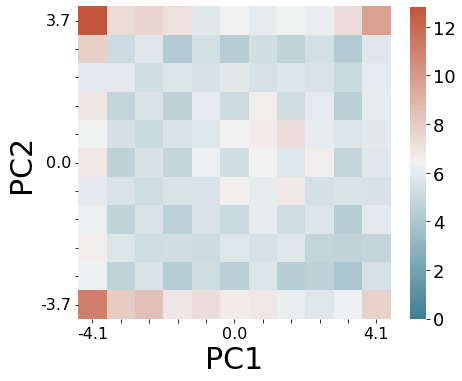

In [14]:
################ heatmap of AVERAGE DWELL TIME #############

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC2', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC2_PC2 avg dwell time heatmap.png', bbox_inches='tight')

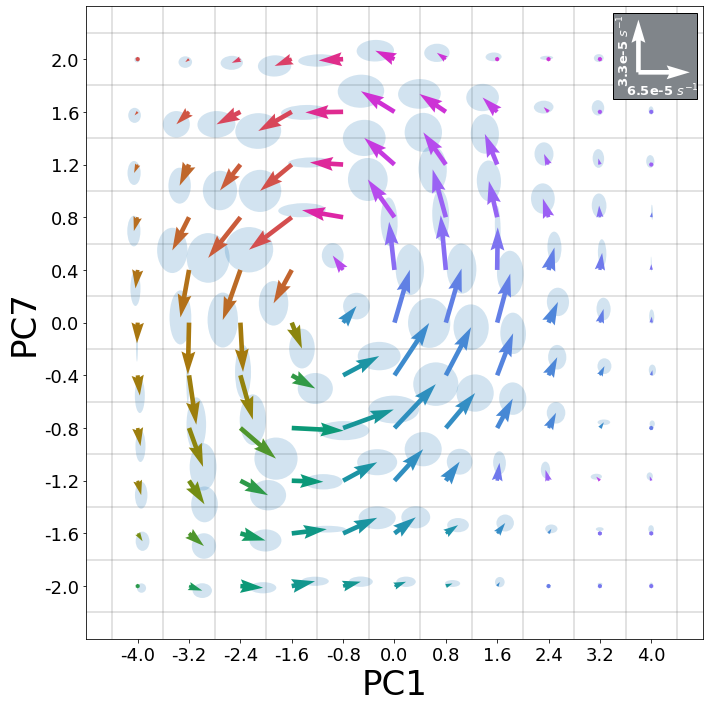

In [7]:
########## PC2/PC7 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0008

# combine fake error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})



fig, ax = plt.subplots(figsize=(10,10))
    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                  height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                angle=np.arctan2(current.evec1y,current.evec1x))
        ax.add_artist(ell)
        ell.set_alpha(0.2)

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC2', fontsize = 34)
ax.set_ylabel('PC7', fontsize = 34)
ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC2.to_list()], fontsize = 18)
ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC7.to_list()], fontsize = 18)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#legend background
lxp = 10.25
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC2.to_list()).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7.to_list()).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC2_PC7 Vector map absolute angle colored.png', bbox_inches='tight')

In [21]:
transdf.columns.to_list()

['frame',
 'from_x',
 'from_y',
 'to_x',
 'to_y',
 'time_elapsed',
 'cumulative_time',
 'CellID']

In [200]:
results

[]

In [188]:
adf.iloc[2480:2500]
# adf.sort_values('aer')

frame  from_x  from_y  to_x  to_y  time_elapsed  cumulative_time  \
2480   56.0     6.0     8.0   6.0   7.0      0.425532      2056.169926   
2481   56.0     6.0     7.0   7.0   7.0      0.585106      2056.755033   
2482   56.0     7.0     7.0   7.0   6.0      0.053191      2056.808224   
2483   56.0     7.0     6.0   7.0   5.0      0.638298      2057.446522   
2484   56.0     7.0     5.0   8.0   5.0      0.265957      2057.712480   
2485   56.0     8.0     5.0   8.0   4.0      0.319149      2058.031629   
2486   56.0     8.0     4.0   8.0   3.0      0.638298      2058.669926   
2487   56.0     8.0     3.0   9.0   3.0      0.053191      2058.723118   
2488   56.0     9.0     3.0   9.0   2.0      0.585106      2059.308224   
2489   56.0     9.0     2.0  10.0   2.0      0.425532      2059.733756   
2490   56.0    10.0     2.0  10.0   1.0      0.212766      2059.946522   
2491   57.0    10.0     1.0   9.0   1.0      0.757761      2060.704283   
2492   57.0     9.0     1.0   8.0   1.0      0.819672      2061.523955   
2493   57.0     8.0     1.0   7.0   1.0      0.819672      2062.343627   
2494   57.0     7.0     1.0   7.0   2.0      0.409836      2062.753463   
2495   57.0     7.0     2.0   6.0   2.0      0.409836      2063.163299   
2496   57.0     6.0     2.0   5.0   2.0      0.819672      2063.982971   
2497   57.0     5.0     2.0   4.0   2.0      0.819672      2064.802643   
2498   58.0     4.0     2.0   3.0   2.0      3.409836      2068.212480   
2499   59.0     3.0     2.0   4.0   2.0      4.500000      2072.712480   

                                                 CellID        aer  
2480  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   1.942239  
2481  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   1.412538  
2482  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01  31.075830  
2483  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   2.589652  
2484  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01  -3.107583  
2485  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   7.768957  
2486  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   3.884479  
2487  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01 -46.613745  
2488  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   5.650151  
2489  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01  -7.768957  
2490  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01  19.422394  
2491  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   5.453468  
2492  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   5.041557  
2493  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   5.041557  
2494  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01  -4.033246  
2495  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   8.066492  
2496  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   4.033246  
2497  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   4.033246  
2498  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01   0.969530  
2499  20240524_488_EGFP-CAAX_640_actin-halotag_cell1_01  -0.734653

In [199]:
adf = pd.concat(results).reset_index(drop = True)
adf
# sns.lineplot(data = adf, x = 'cumulative_time',y = 'aer', hue = 'CellID', legend=None)

ValueError: No objects to concatenate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-90.70243636152344 0.0


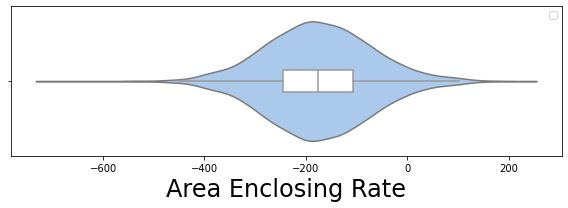

In [21]:
import scipy.stats as stats
t_statistic, p_value = stats.ttest_1samp(a=allaers.aer, popmean=0) 
print(t_statistic , p_value)
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(8,3))#, sharex=True)
#plots
sns.violinplot(data=allaers, x = 'aer',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=allaers,x='aer', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labelste
ax.set_xlabel('Area Enclosing Rate', fontsize=24)#, labelpad=-5)
ax.set_ylabel('', fontsize=20)
ax.tick_params('y', labelsize=16)
ax.set_yticklabels([''], fontsize = 14)
# ax.text(255,0,'***',fontdict= {'fontsize': 22,
#                                'horizontalalignment':'center'})


plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'alldata aer.png', bbox_inches='tight', dpi = 500)


In [22]:
######### do NORMALIZED contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,4]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv'):
    omegas_norm = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = True))
    omegas_norm = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas_norm.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

(210.32165930822035, 0.0)


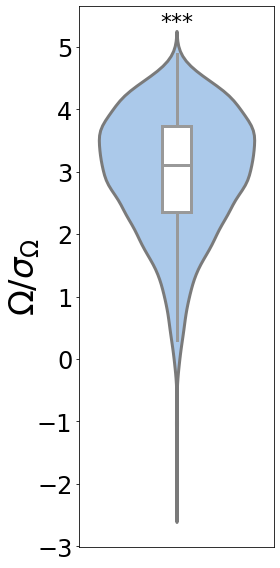

In [38]:
################ histograms of the contour integral distributions ###########
from statsmodels.stats.weightstats import ztest as ztest
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas_norm, y = 'Norm_Omegas',
               palette = colorlist, linewidth = 3, inner = None, ax=ax)
sns.boxplot(data=omegas_norm,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, linewidth = 3, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=34, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=24)
ax.set_xticklabels([''], fontsize = 14)
ax.set_xticks([])

ax.text(0,5.3,'***',fontdict= {'fontsize': 22,
                               'horizontalalignment':'center'})
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} normalized.png', bbox_inches='tight', dpi = 500)
print(str(ztest(omegas_norm.Norm_Omegas, value=0)))

In [ ]:
################## how are the PC bins changing over time #########################
difflist = []
for i, d in TotalFrame[['CellID','Migration_Mode','frame','PC2bins','PC2bins','PC3bins','PC4bins']].sort_values(by='frame').groupby('CellID'):
    dtemp = d[['frame','PC2bins','PC2bins','PC3bins','PC4bins']].diff()
    dtemp = dtemp[dtemp.frame==1]
    dtemp['frame'] = d.frame[dtemp.index]
    dtemp['CellID'] =  [i]*len(dtemp)
    dtemp['Migration_Mode'] = d.Migration_Mode[dtemp.index]
    difflist.append(dtemp)
diffdf = pd.concat(difflist)

fig, axes = plt.subplots(4, 1, figsize=(20,40), sharey=True)
for a, ax in enumerate(axes):
    cpc = [x for x in diffdf.columns.to_list() if 'PC' in x][a]
    sns.boxplot(data=diffdf, x='frame', hue='Migration_Mode',y=cpc, ax=ax)
    ax.set_xticklabels(
        np.sort(diffdf.frame.unique()).astype(int),
        rotation=-45,
        fontsize = 12
        )
    #set axis titles
    ax.set_ylabel(cpc, fontsize = 30)
    ax.set_xlabel('Frame', fontsize = 22)
plt.tight_layout()
fig.savefig(savedir+'PC bin differentials.png', facecolor='white')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in 

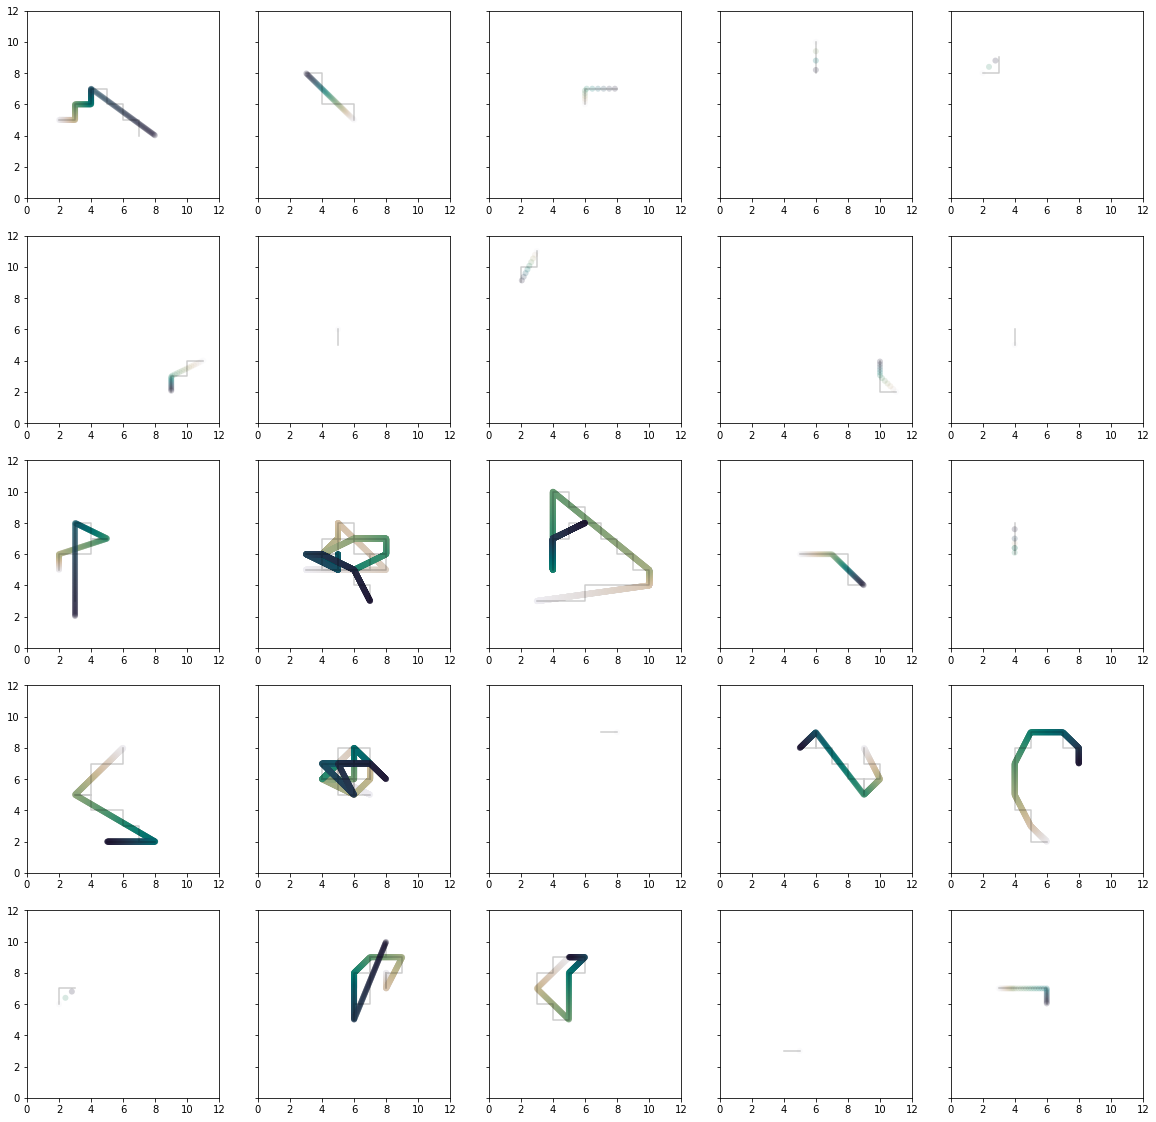

In [45]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC2bins.to_numpy()
        py = acttemp.PC2bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [4]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCvisualization import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()

pca = pk.load(open('/'.join(savedir.split('/')[:-2])+"/pca.pkl",'rb'))

PC2bins = centers.PC2.to_numpy()
PC2bins = centers.PC2.to_numpy()

whichpcs = [1,2]
lmax = 10
metrics = ['speed']
vertices = np.array([[8,8],
                    [8,3],
                    [3,3],
                    [3,8]])

contour_positions, loopname, metricsarray = interpolate_contour_shapes(vertices,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC2bins,
                               PC2bins,
                               savedir,
                               lmax,
                               TotalFrame,
                               metrics)



In [10]:
pd.DataFrame(metricsarray)

arbitrarytime  PC1bin  PC2bin     speed
0            0.000     8.0     8.0  0.071839
1            0.005     8.0     7.9  0.071839
2            0.010     8.0     7.8  0.071839
3            0.015     8.0     7.7  0.071839
4            0.020     8.0     7.6  0.071839
..             ...     ...     ...       ...
195          0.975     7.5     8.0  0.071839
196          0.980     7.6     8.0  0.071839
197          0.985     7.7     8.0  0.071839
198          0.990     7.8     8.0  0.071839
199          0.995     7.9     8.0  0.071839

[200 rows x 4 columns]

In [ ]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC2', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC2-PC2.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [4]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCvisualization import mesh_from_bins
import pickle as pk

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and 'dist' not in x]].mean().to_numpy()

pca = pk.load(open(datadir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



specific_positions = np.array([
[3,8],
[5.5,8],
[8,8],
[8,6],
[8,4],
[5.5,4],
[3,4],
[3,6]])



for x in specific_positions:
    specificdir = savedir + str(x) + '.vtp'
    mesh_from_bins(x,
                   whichpcs,
                   avgpcs,
                   PC2bins,
                   PC2bins,
                   pca,
                   specificdir,
                   lmax,
                   )
